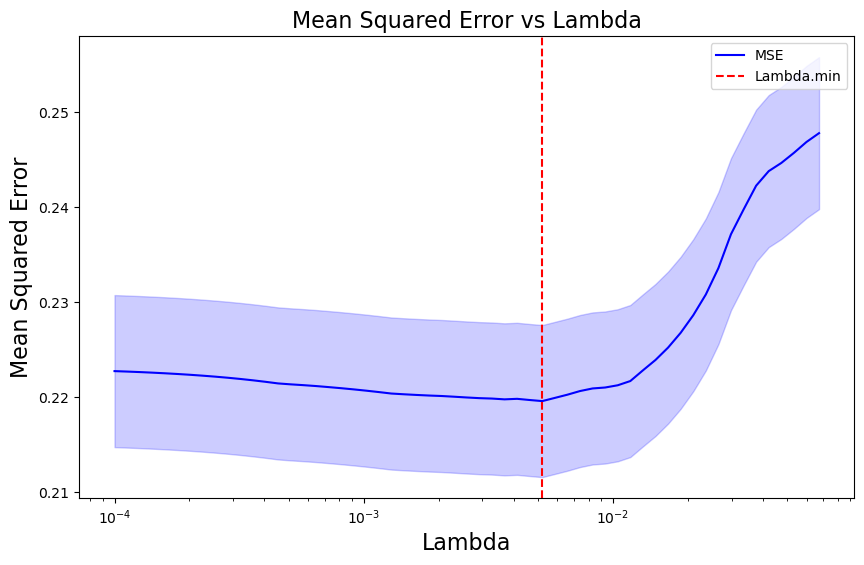

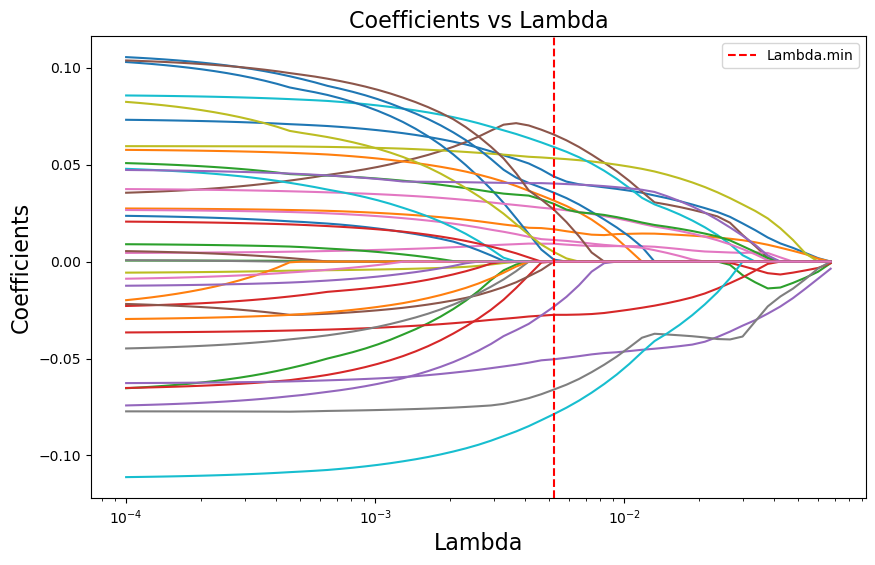

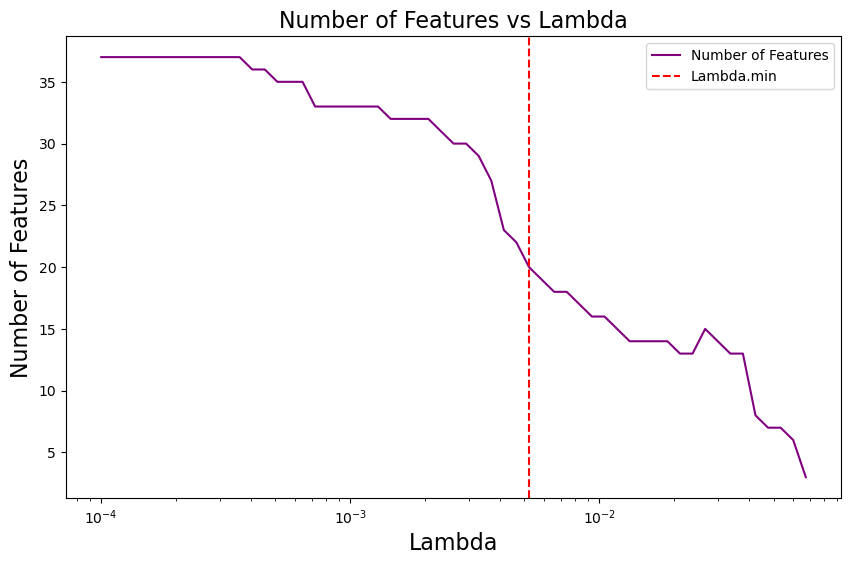

Optimal lambda: 0.005214008287999685
-log10(lambda): 2.282828282828283


In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 步骤1: 读取数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_pvalues = r'C:\Users\Admin\Desktop\数据分析\亚组分析\p值5.xlsx'

features_data = pd.read_excel(file_path_features)
pvalues_data = pd.read_excel(file_path_pvalues)

# 步骤2: 根据p值筛选特征
significant_features = pvalues_data[pvalues_data['P_Value'] < 0.05]['Feature'].values
significant_features_data = features_data[significant_features]

# 准备数据进行LASSO回归
X = significant_features_data.values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# 步骤3: 使用LASSO回归进行特征选择
alphas = np.logspace(-4, 1, 100)
lasso = Lasso(max_iter=10000)
mse_path = []
coefs_path = []
non_zero_coefs_count = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X_train, y_train)
    mse_path.append(mean_squared_error(y_test, lasso.predict(X_test)))
    coefs = lasso.coef_
    coefs[np.abs(coefs) < 1e-10] = 0  # 将接近零的系数设置为零
    coefs_path.append(coefs)
    non_zero_coefs_count.append(np.sum(coefs != 0))

# 将列表转换为NumPy数组
mse_path = np.array(mse_path)
non_zero_coefs_count = np.array(non_zero_coefs_count)
coefs_path = np.array(coefs_path)

# 筛选出至少有一个非零系数的alpha值
valid_idx = non_zero_coefs_count > 0
valid_alphas = alphas[valid_idx]
valid_mse_path = mse_path[valid_idx]
valid_coefs_path = coefs_path[valid_idx]
valid_non_zero_coefs_count = non_zero_coefs_count[valid_idx]

# 找到最小MSE对应的alpha
idx_min_mse = np.argmin(valid_mse_path)
alpha_min_mse = valid_alphas[idx_min_mse]

# 保存筛选出的特征及其系数到Excel文件
selected_features_df = pd.DataFrame({
    'Feature': significant_features,
    'Coefficient': valid_coefs_path[idx_min_mse, :]
})
selected_features_df.to_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx', index=False)

# 绘制模型均方差随Log（λ）的变化的图并保存
plt.figure(figsize=(10, 6))
plt.semilogx(valid_alphas, valid_mse_path, label='MSE', color='blue')
plt.fill_between(valid_alphas, valid_mse_path - np.std(valid_mse_path), valid_mse_path + np.std(valid_mse_path), color='blue', alpha=0.2)
plt.axvline(alpha_min_mse, linestyle='--', color='red', label='Lambda.min')
plt.xlabel('Lambda', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.title('Mean Squared Error vs Lambda', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\MSE_vs_log_lambda.tiff',dpi=300, bbox_inches='tight')
plt.show()

# 绘制LASSO回归模型减少变量数目和调整系数的过程的图并保存
plt.figure(figsize=(10, 6))
for i in range(valid_coefs_path.shape[1]):
    plt.semilogx(valid_alphas, valid_coefs_path[:, i])
plt.axvline(alpha_min_mse, linestyle='--', color='red', label='Lambda.min')
plt.xlabel('Lambda', fontsize=16)
plt.ylabel('Coefficients', fontsize=16)
plt.title('Coefficients vs Lambda', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\Coefficients_vs_log_lambda.tiff',dpi=300, bbox_inches='tight')
plt.show()

# 绘制模型所需变量数目随Log(λ)的变化图并保存
plt.figure(figsize=(10, 6))
plt.semilogx(valid_alphas, valid_non_zero_coefs_count, label='Number of Features', color='purple')
plt.axvline(alpha_min_mse, linestyle='--', color='red', label='Lambda.min')
plt.xlabel('Lambda', fontsize=16)
plt.ylabel('Number of Features', fontsize=16)
plt.title('Number of Features vs Lambda', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\Number_of_Features_vs_log_lambda.tiff',dpi=300, bbox_inches='tight')
plt.show()

# 输出λ值和-Log（λ）值
print(f"Optimal lambda: {alpha_min_mse}")
print(f"-log10(lambda): {-np.log10(alpha_min_mse)}")

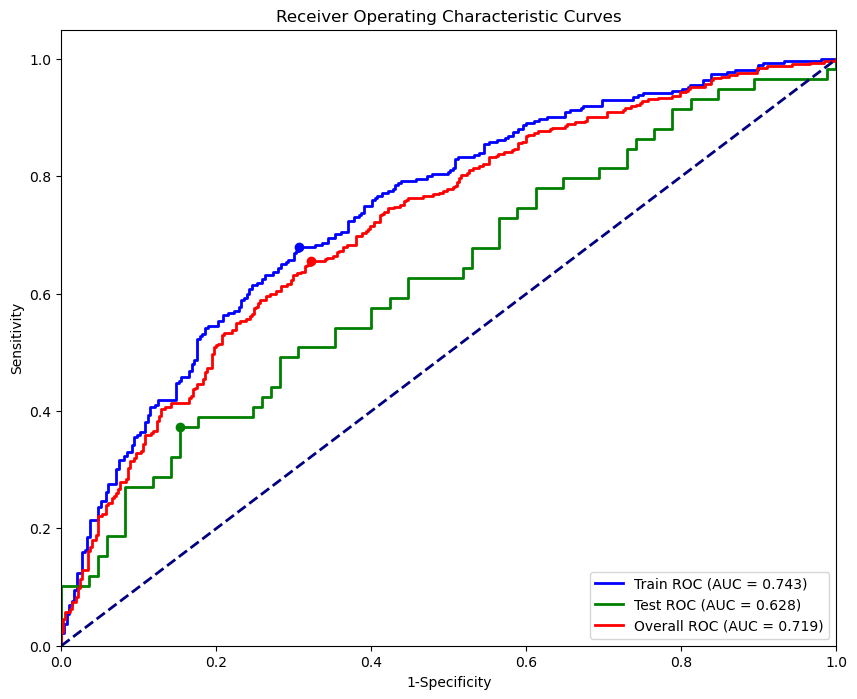

Train Sensitivity: 0.680, Specificity: 0.694
Test Sensitivity: 0.373, Specificity: 0.847
Overall Sensitivity: 0.656, Specificity: 0.678


In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 步骤1: 读取数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_selected_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx'

features_data = pd.read_excel(file_path_features)
selected_features_data = pd.read_excel(file_path_selected_features)

# 步骤2: 根据LASSO筛选的特征系数不为0的特征
non_zero_features = selected_features_data[selected_features_data['Coefficient'] != 0]['Feature'].values
X = features_data[non_zero_features].values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 步骤3: 划分训练集和测试集（8:2比例）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用逻辑回归模型
logistic_regression = LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train, y_train)

# 计算训练集、测试集和总体的预测概率
y_train_pred_proba = logistic_regression.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
overall_pred_proba = logistic_regression.predict_proba(X_scaled)[:, 1]

# 计算ROC曲线和AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_overall, tpr_overall, _ = roc_curve(y, overall_pred_proba)
roc_auc_overall = auc(fpr_overall, tpr_overall)

# 找到最佳点（敏感性特异性之和最大值的点）
def find_best_point(fpr, tpr):
    max_sum = 0
    best_point = (0, 0)
    for i in range(len(fpr)):
        sum_sensitivity_specificity = tpr[i] + (1 - fpr[i])
        if sum_sensitivity_specificity > max_sum:
            max_sum = sum_sensitivity_specificity
            best_point = (fpr[i], tpr[i])
    return best_point

best_point_train = find_best_point(fpr_train, tpr_train)
best_point_test = find_best_point(fpr_test, tpr_test)
best_point_overall = find_best_point(fpr_overall, tpr_overall)

# 绘制ROC曲线并保存
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.3f})')
plt.plot(fpr_overall, tpr_overall, color='red', lw=2, label=f'Overall ROC (AUC = {roc_auc_overall:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")

# 标注最佳点
plt.scatter(best_point_train[0], best_point_train[1], color='blue', label=f'Train Best Point (FPR: {best_point_train[0]:.3f}, TPR: {best_point_train[1]:.3f})')
plt.scatter(best_point_test[0], best_point_test[1], color='green', label=f'Test Best Point (FPR: {best_point_test[0]:.3f}, TPR: {best_point_test[1]:.3f})')
plt.scatter(best_point_overall[0], best_point_overall[1], color='red', label=f'Overall Best Point (FPR: {best_point_overall[0]:.3f}, TPR: {best_point_overall[1]:.3f})')

plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\ROC_curves2.tiff', dpi=300)
plt.show()

# 输出模型在训练集、测试集和总体集的敏感性和特异性
train_sensitivity = best_point_train[1]
train_specificity = 1 - best_point_train[0]

test_sensitivity = best_point_test[1]
test_specificity = 1 - best_point_test[0]

overall_sensitivity = best_point_overall[1]
overall_specificity = 1 - best_point_overall[0]

print(f"Train Sensitivity: {train_sensitivity:.3f}, Specificity: {train_specificity:.3f}")
print(f"Test Sensitivity: {test_sensitivity:.3f}, Specificity: {test_specificity:.3f}")
print(f"Overall Sensitivity: {overall_sensitivity:.3f}, Specificity: {overall_specificity:.3f}")

# 获取逻辑回归模型的系数
logistic_coefficients = logistic_regression.coef_[0]
intercept = logistic_regression.intercept_[0]

# 创建一个DataFrame来保存特征和对应的系数
logistic_coefficients_df = pd.DataFrame({
    'Feature': non_zero_features,
    'Logistic Coefficient': logistic_coefficients
})

# 添加截距到DataFrame
logistic_coefficients_df.loc[len(logistic_coefficients_df)] = ['Intercept', intercept]

# 保存逻辑回归系数到Excel文件
logistic_coefficients_df.to_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Logistic_Coefficients.xlsx', index=False)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 从Excel文件中读取逻辑回归系数
logistic_coefficients_df = pd.read_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Logistic_Coefficients.xlsx')

# 根据系数的大小从小到大排序
sorted_coefficients_df = logistic_coefficients_df.sort_values(by='Logistic Coefficient')

# 绘制逻辑回归系数的柱状图
plt.figure(figsize=(15, 15), dpi=300)
color_map = plt.cm.colormap  # 可以选择其他colormap，如 'plasma', 'inferno', 'magma'
colors = color_map(np.linspace(0, 1, len(sorted_coefficients_df)))

font_y = FontProperties(family='Times New Roman', size=8, weight='light')
plt.yticks(fontproperties=font_y)
plt.barh(sorted_coefficients_df['Feature'], sorted_coefficients_df['Logistic Coefficient'], color=colors)
plt.ylabel('Feature', fontsize=14, fontweight='light')
plt.xlabel('Coefficient Value', fontsize=14, fontweight='light')
plt.title('Feature Coefficients in Logistic Regression', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.gca().invert_xaxis()  # 反转x轴，使柱状图按系数值从小到大排列
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Logistic_Regression_Coefficients2.tiff', dpi=300, bbox_inches='tight')
plt.show()

AttributeError: module 'matplotlib.cm' has no attribute 'colormap'

<Figure size 4500x4500 with 0 Axes>

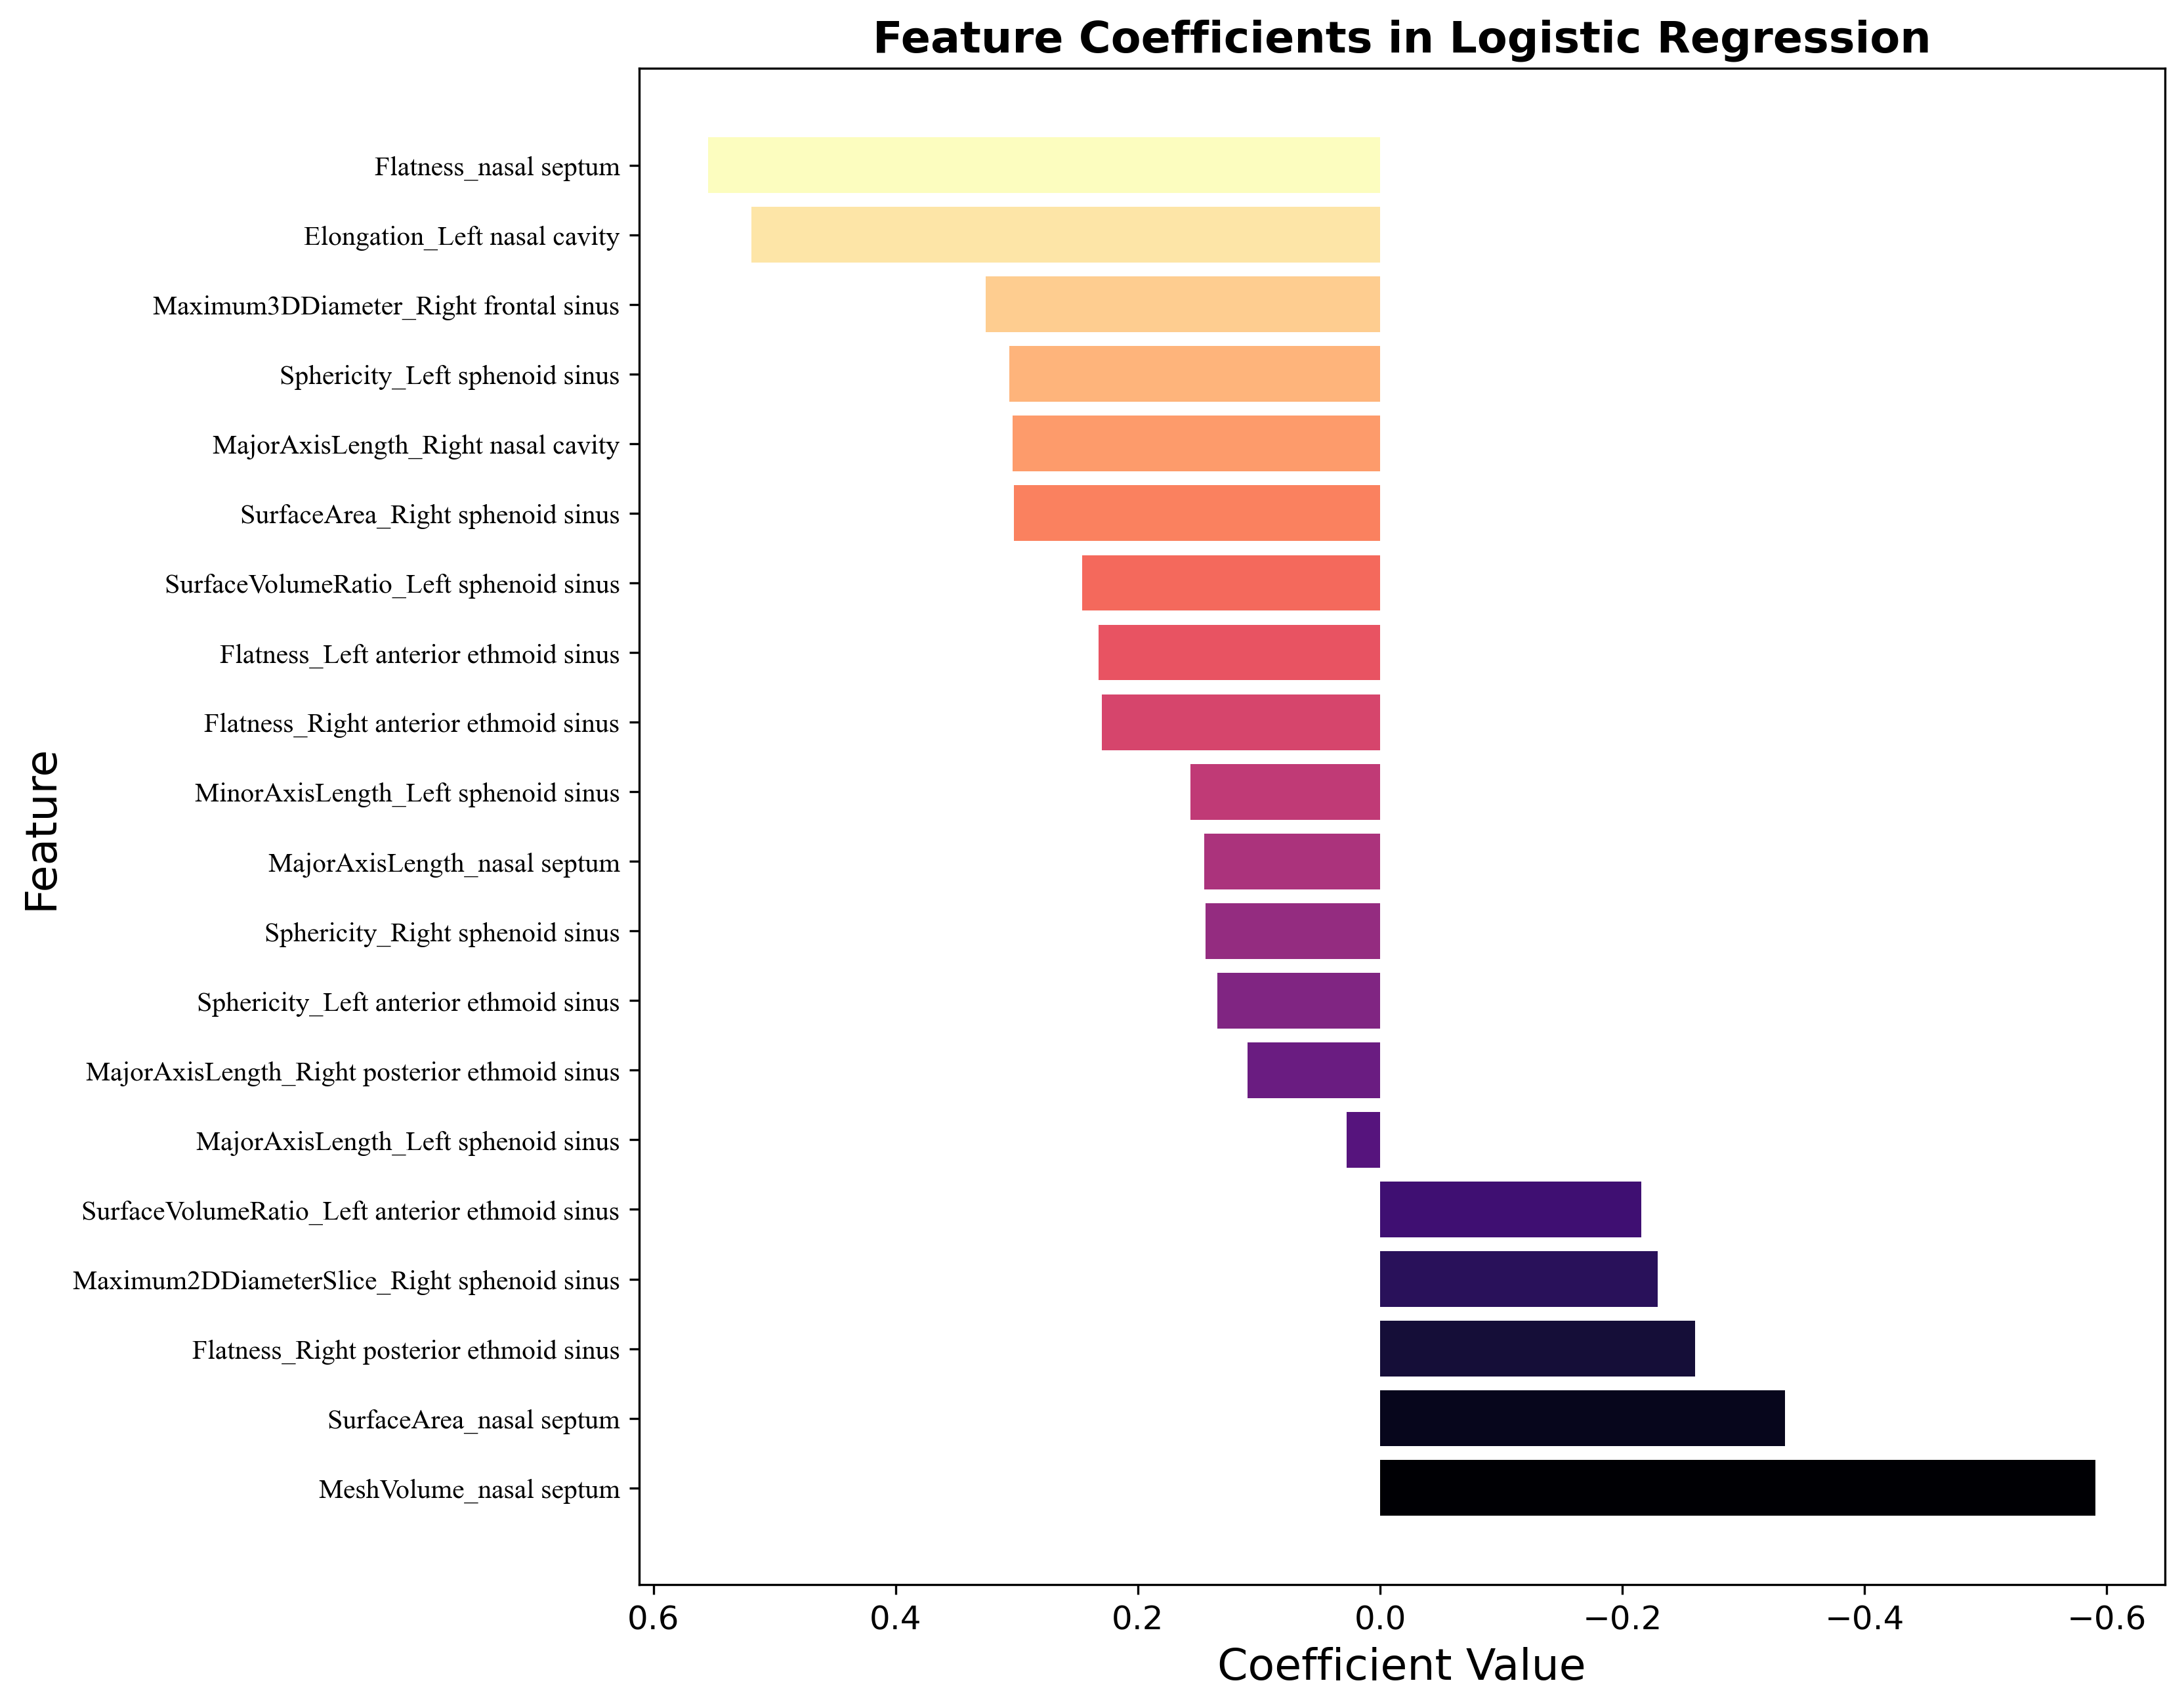

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 从Excel文件中读取逻辑回归系数
logistic_coefficients_df = pd.read_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Logistic_Coefficients.xlsx')

# 根据系数的大小从小到大排序
sorted_coefficients_df = logistic_coefficients_df.sort_values(by='Logistic Coefficient')

# 绘制逻辑回归系数的柱状图
plt.figure(figsize=(10, 10), dpi=300)
color_map = plt.cm.magma  # 可以选择其他colormap，如 'plasma', 'inferno', 'magma'
colors = color_map(np.linspace(0, 1, len(sorted_coefficients_df)))

font_y = FontProperties(family='Times New Roman', size=8, weight='light')
plt.yticks(fontproperties=font_y)
plt.barh(sorted_coefficients_df['Feature'], sorted_coefficients_df['Logistic Coefficient'], color=colors)
plt.ylabel('Feature', fontsize=16, fontweight='light')
plt.xlabel('Coefficient Value', fontsize=16, fontweight='light')
plt.title('Feature Coefficients in Logistic Regression', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.gca().invert_xaxis()  # 反转x轴，使柱状图按系数值从小到大排列
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Logistic_Regression_Coefficients2.tiff', dpi=300, bbox_inches='tight')
plt.show()

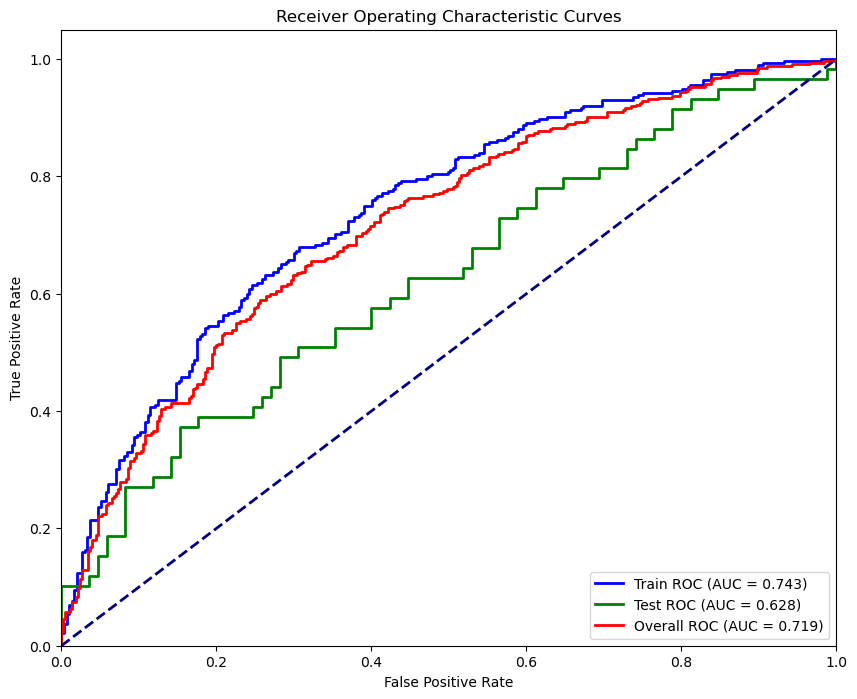

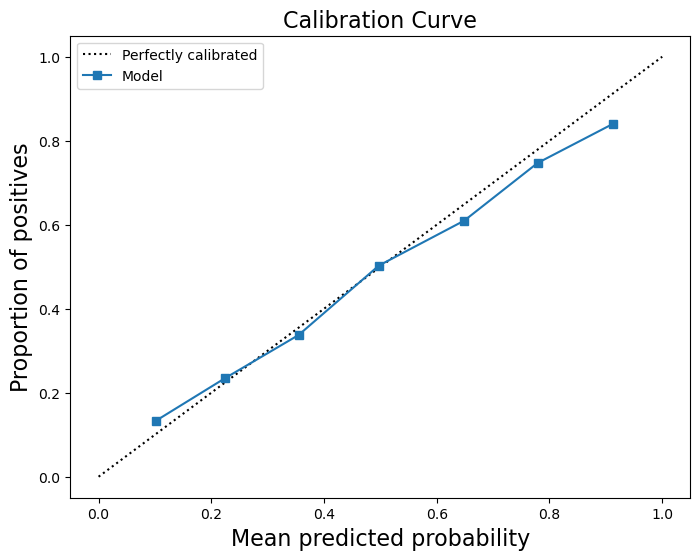

Train Sensitivity: 0.680, Specificity: 0.694
Test Sensitivity: 0.373, Specificity: 0.847
Overall Sensitivity: 0.656, Specificity: 0.678


In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 读取数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_selected_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx'

features_data = pd.read_excel(file_path_features)
selected_features_data = pd.read_excel(file_path_selected_features)

# 根据LASSO筛选的特征系数不为0的特征
non_zero_features = selected_features_data[selected_features_data['Coefficient'] != 0]['Feature'].values
X = features_data[non_zero_features].values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集（8:2比例）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用逻辑回归模型
logistic_regression = LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train, y_train)

# 计算训练集、测试集和总体的预测概率
y_train_pred_proba = logistic_regression.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
overall_pred_proba = logistic_regression.predict_proba(X_scaled)[:, 1]

# 计算ROC曲线和AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_overall, tpr_overall, _ = roc_curve(y, overall_pred_proba)
roc_auc_overall = auc(fpr_overall, tpr_overall)

# 绘制ROC曲线并保存
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.3f})')
plt.plot(fpr_overall, tpr_overall, color='red', lw=2, label=f'Overall ROC (AUC = {roc_auc_overall:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\ROC_curves.tiff', dpi=300)
plt.show()

# 计算校准曲线
prob_true, prob_pred = calibration_curve(y, logistic_regression.predict_proba(X_scaled)[:, 1], n_bins=7, strategy='uniform')

# 绘制校准曲线并保存
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Model')
plt.xlabel('Mean predicted probability', fontsize=16)
plt.ylabel('Proportion of positives', fontsize=16)
plt.title('Calibration Curve', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\Calibration_Curve.tiff', dpi=300)
plt.show()

# 输出模型在训练集、测试集和总体集的敏感性和特异性
train_sensitivity = best_point_train[1]
train_specificity = 1 - best_point_train[0]

test_sensitivity = best_point_test[1]
test_specificity = 1 - best_point_test[0]

overall_sensitivity = best_point_overall[1]
overall_specificity = 1 - best_point_overall[0]

print(f"Train Sensitivity: {train_sensitivity:.3f}, Specificity: {train_specificity:.3f}")
print(f"Test Sensitivity: {test_sensitivity:.3f}, Specificity: {test_specificity:.3f}")
print(f"Overall Sensitivity: {overall_sensitivity:.3f}, Specificity: {overall_specificity:.3f}")

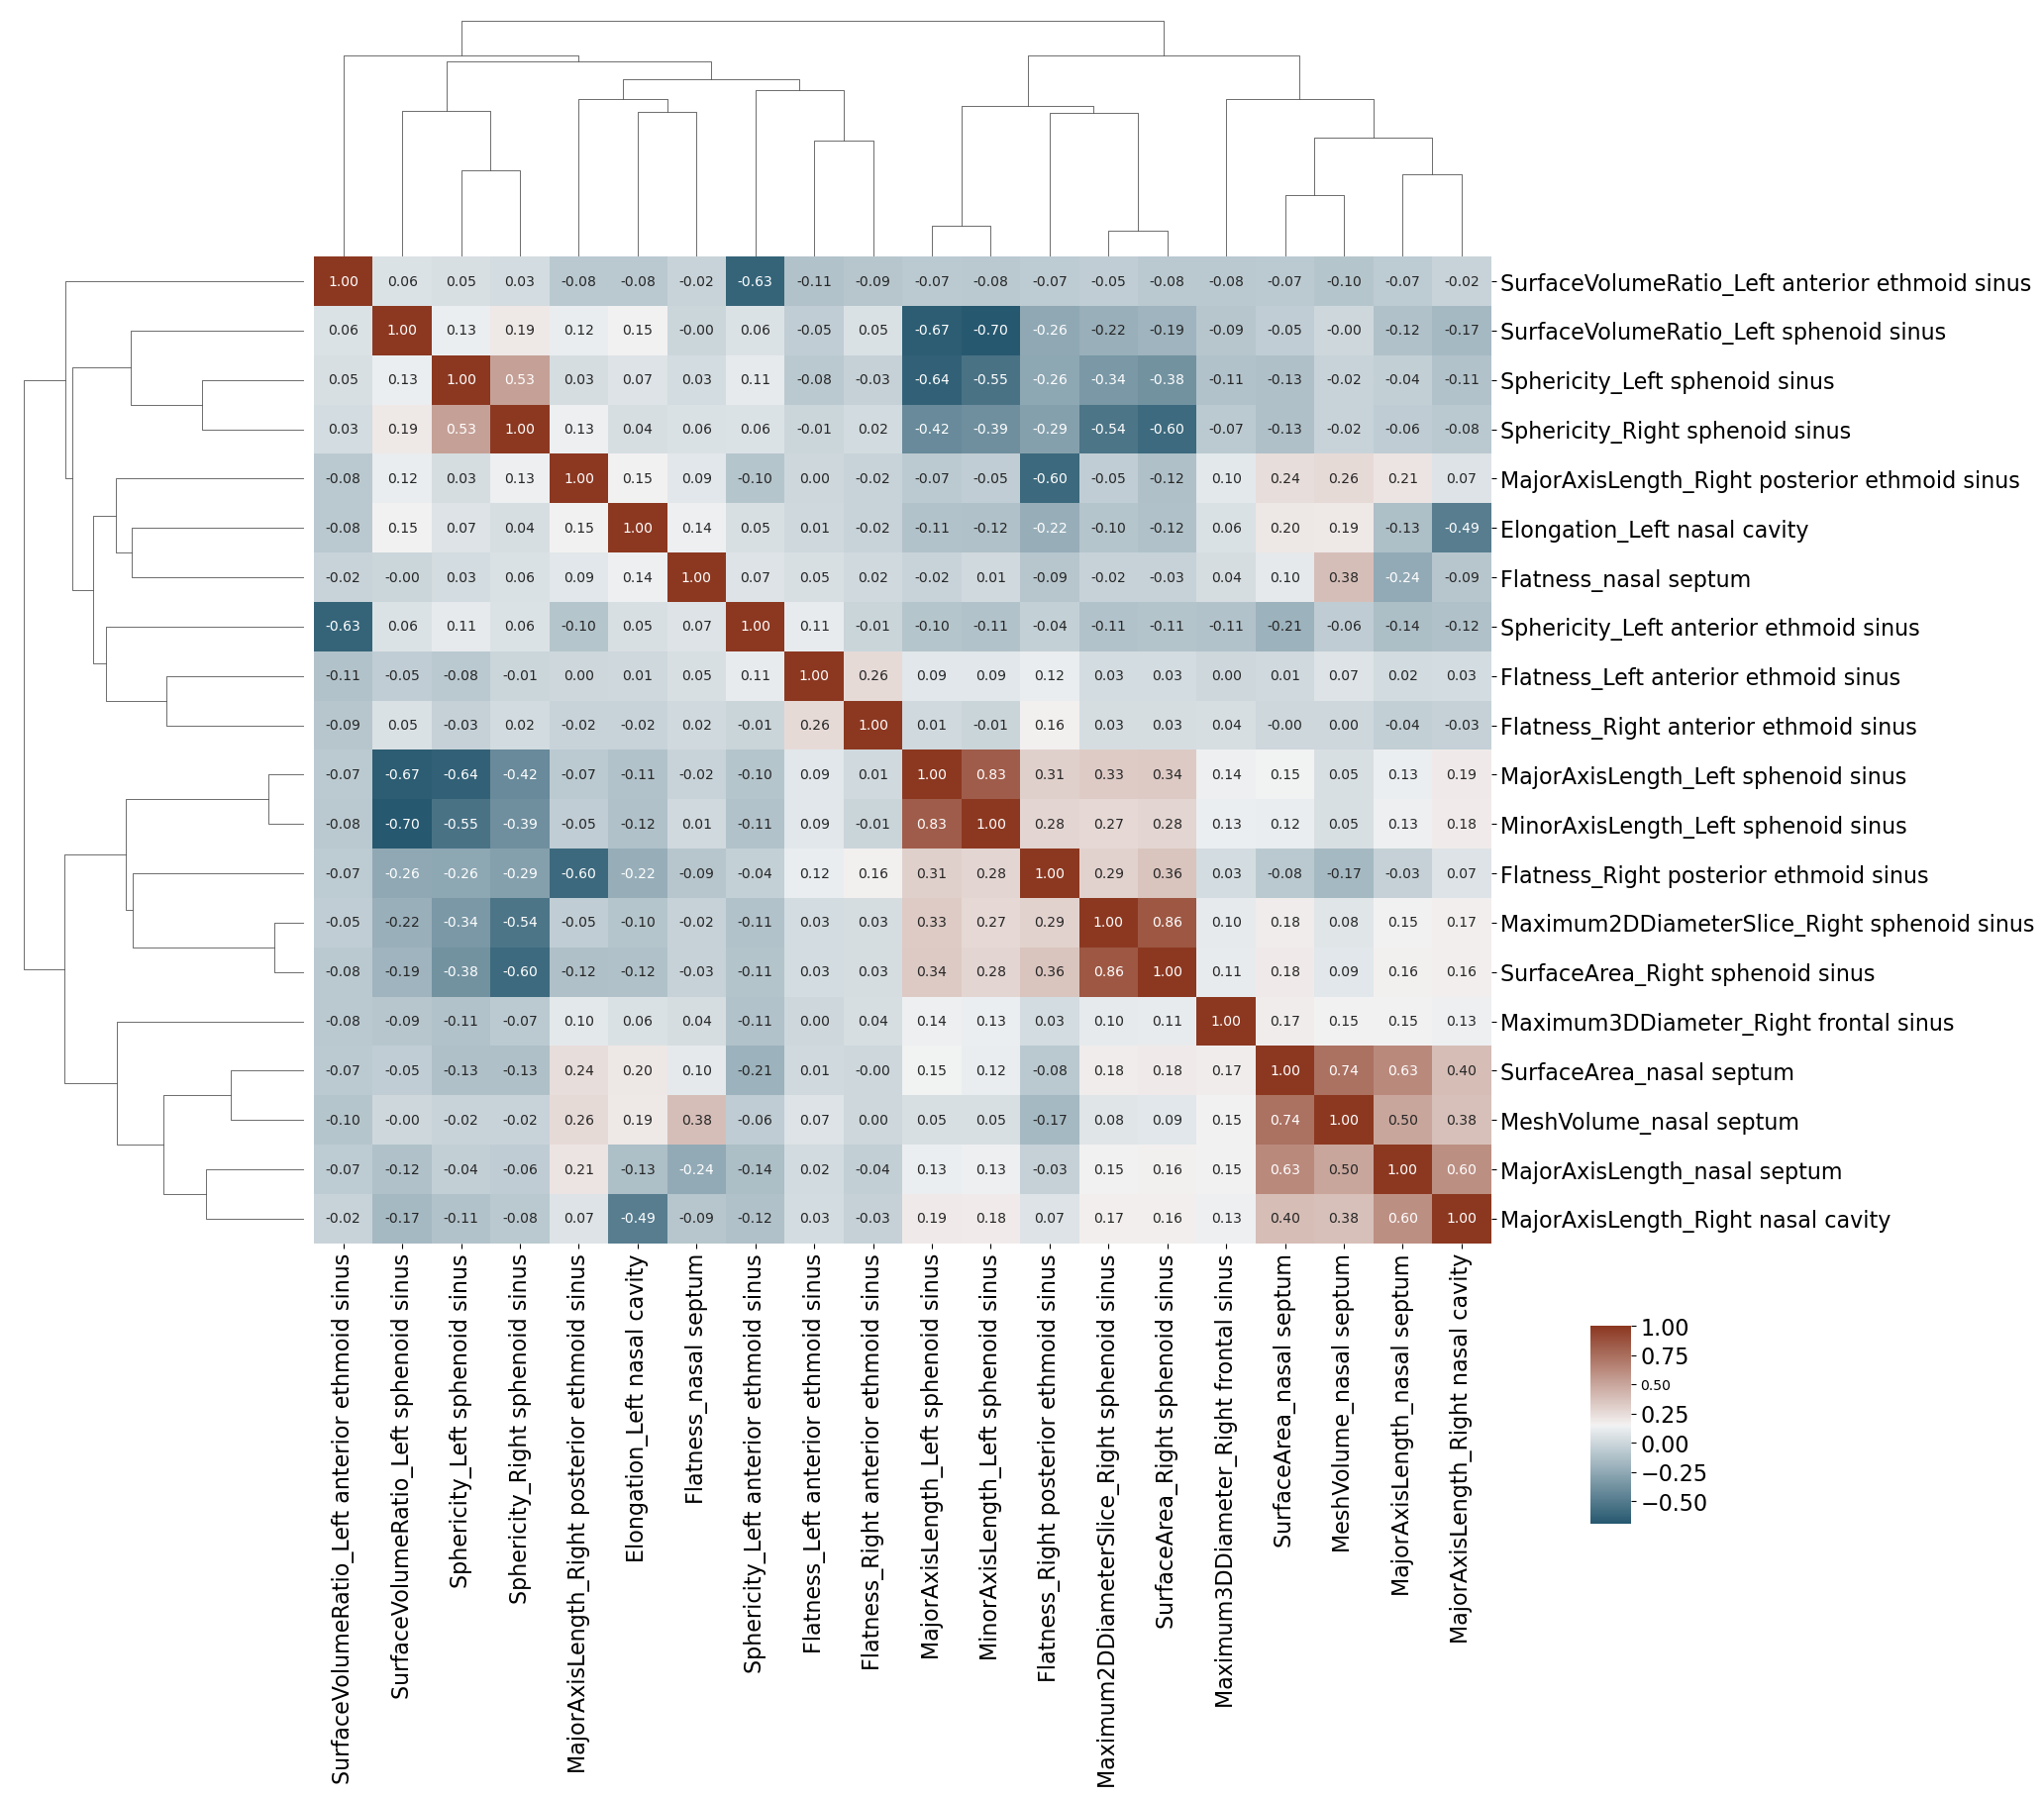

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 读取数据
file_path1 = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path2 = r'C:\Users\Admin\Desktop\数据分析\亚组分析\Logistic_Coefficients.xlsx'

df1 = pd.read_excel(file_path1)
df2 = pd.read_excel(file_path2)

# 筛选特征
features = df2['Feature'].tolist()
df_features = df1[features]

# 计算相关系数
correlation_matrix = df_features.corr()

# 定义一个较暗的颜色映射
dark_cmap = sns.diverging_palette(230, 20, s=80, l=35, n=3, as_cmap=True)

# 创建聚类热图
g = sns.clustermap(correlation_matrix, annot=True, cmap=dark_cmap, fmt='.2f',
                   xticklabels=features, yticklabels=features, cbar_kws={'shrink': .5})

# 设置标题和字体大小，并调整标题位置
#g.ax_heatmap.set_title('Feature Correlation Heatmap', fontsize=28, pad=220)  # pad控制标题与图像的距离

# 设置x轴和y轴标签的旋转角度和字体大小
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=16)  # 设置x轴标签的字体大小
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=16)  # 设置y轴标签的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# 将颜色条（color bar）移动到右侧
g.cax.set_position([.68, .22, .017, .10])



# 调整图像大小
g.fig.set_size_inches(24, 20)

# 显示图像
plt.show()

# 保存图像，指定DPI
g.fig.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\correlation_heatmap2.tiff', dpi=300)

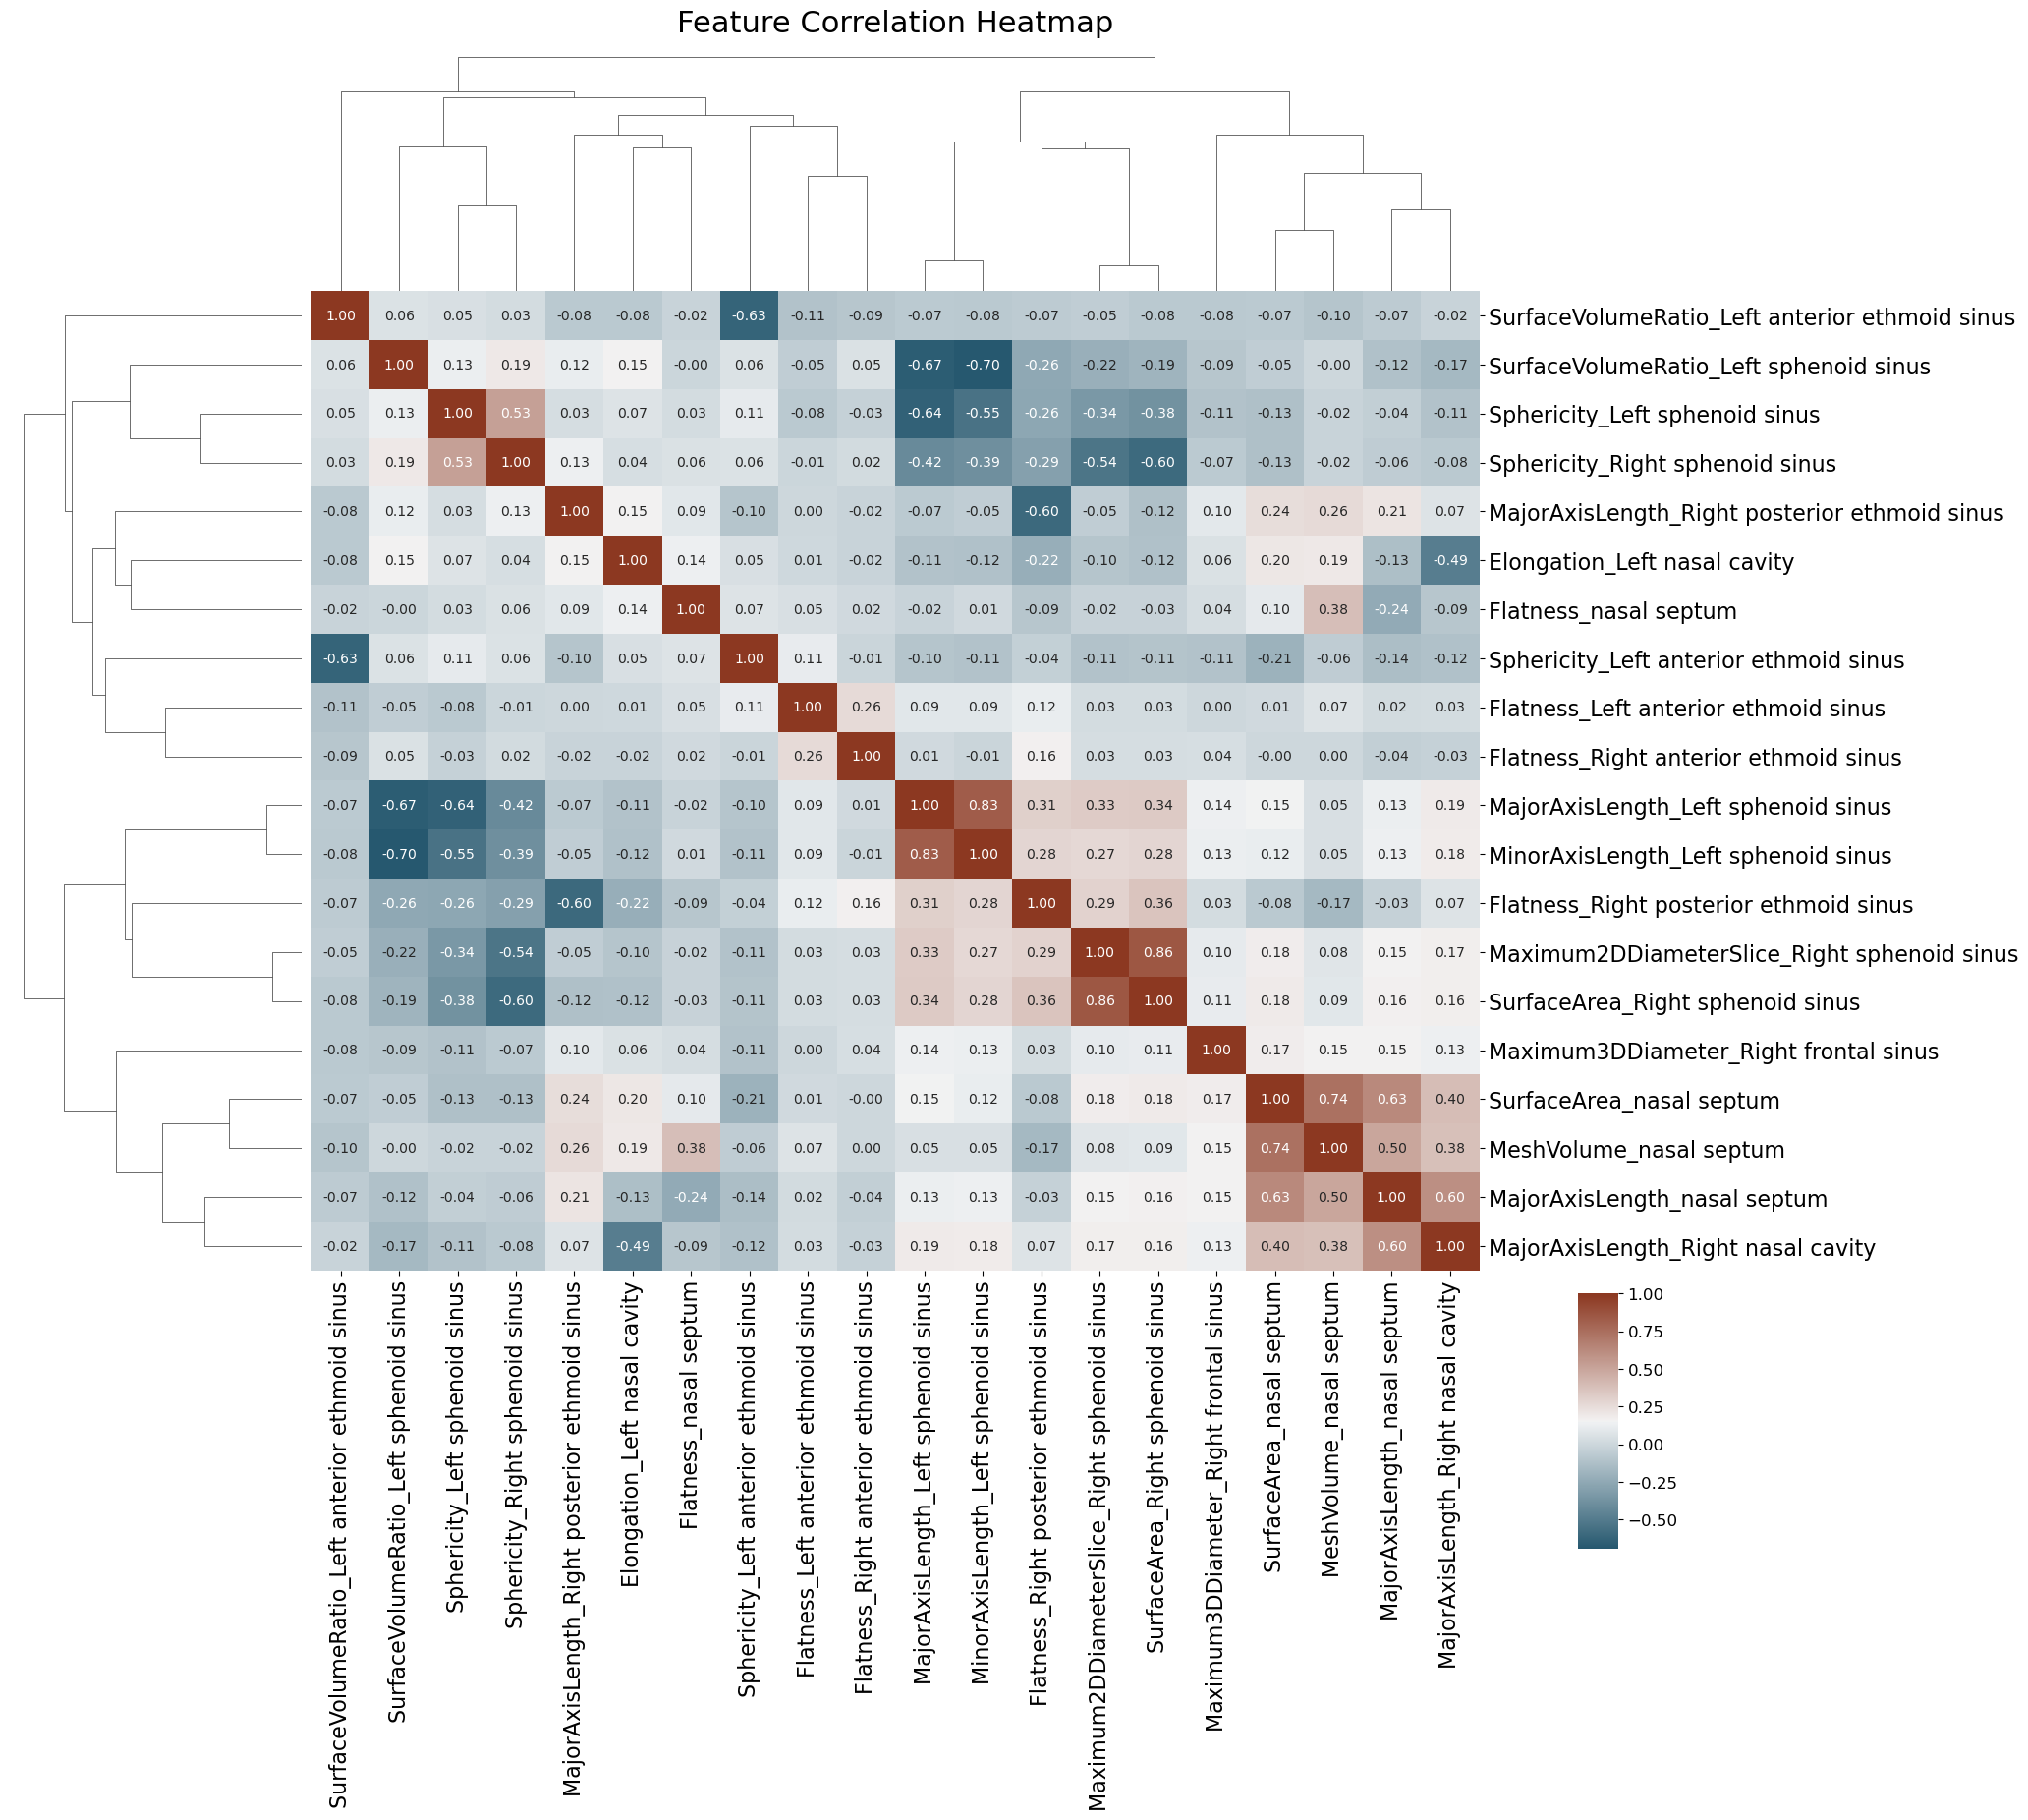

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
file_path1 = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path2 = r'C:\Users\Admin\Desktop\数据分析\亚组分析\Logistic_Coefficients.xlsx'

df1 = pd.read_excel(file_path1)
df2 = pd.read_excel(file_path2)

# 筛选特征
features = df2['Feature'].tolist()
df_features = df1[features]

# 计算相关系数
correlation_matrix = df_features.corr()

# 定义一个较暗的颜色映射
dark_cmap = sns.diverging_palette(230, 20, s=80, l=35, n=3, as_cmap=True)

# 创建聚类热图
g = sns.clustermap(correlation_matrix, annot=True, cmap=dark_cmap, fmt='.2f',
                   xticklabels=features, yticklabels=features, cbar_kws={'shrink': .5})

#设置标题和字体大小，并调整标题位置
g.ax_heatmap.set_title('Feature Correlation Heatmap', fontsize=22, pad=190)  # pad控制标题与图像的距离

# 设置x轴和y轴标签的旋转角度和字体大小
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=16)  # 设置x轴标签的字体大小
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=16)  # 设置y轴标签的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 将颜色条（color bar）移动到右侧
g.cax.set_position([.68, .22, .017, .13])

# 设置颜色条的字体大小
g.cax.tick_params(labelsize=12)  # 这里的12是你想要设置的字体大小

# 调整图像大小
g.fig.set_size_inches(24, 20)

# 显示图像
plt.show()

# 保存图像，指定DPI
g.fig.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\correlation_heatmap3.tiff', dpi=300)

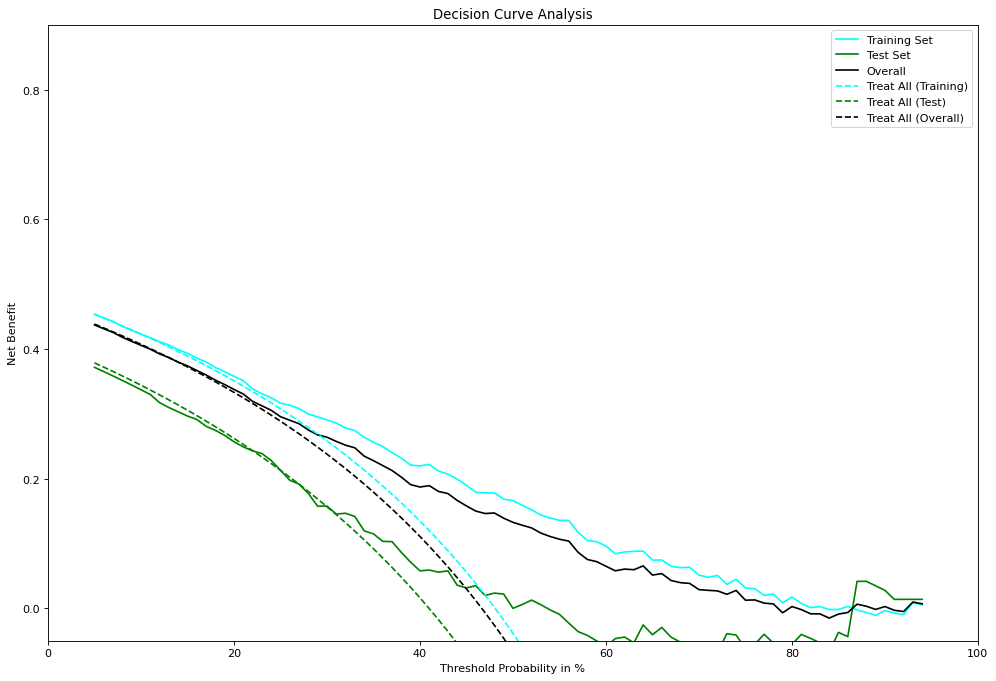

In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 加载数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_selected_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx'

features_data = pd.read_excel(file_path_features)
selected_features_data = pd.read_excel(file_path_selected_features)

# 根据LASSO筛选的特征系数不为0的特征
non_zero_features = selected_features_data[selected_features_data['Coefficient'] != 0]['Feature'].values
X = features_data[non_zero_features].values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集（8:2比例）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用逻辑回归模型
logistic_regression = LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train, y_train)

# 计算预测概率
y_train_pred_proba = logistic_regression.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
y_pred_proba = logistic_regression.predict_proba(X_scaled)[:, 1]

# 决策曲线分析函数
def decision_curve_analysis(y_true, y_pred_proba, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    for p in np.arange(p_min, p_max, epsilon):
        y_pred = y_pred_proba > p
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n = tn + fp + fn + tp
        net_benefit = (tp / n) - (fp / n) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Net Benefit Prioritise All Referrals
def calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    total = tp_test + tn_test
    for p in np.arange(p_min, p_max, epsilon):
        net_benefit = (tp_test / total) - (tn_test / total) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Plotting the Decision Curves
def plot_decision_curves(clfs, labels, X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, name):
    tp_test = np.sum(y_test)
    tn_test = y_test.shape[0] - tp_test
    tp_train = np.sum(y_train)
    tn_train = y_train.shape[0] - tp_train
    tp_overall = np.sum(y)
    tn_overall = y.shape[0] - tp_overall

    plt.figure(figsize=(15, 10), dpi=80)

    # 计算训练集、测试集和总体的决策曲线
    p_train, net_benefit_train = decision_curve_analysis(y_train, clfs[0].predict_proba(X_train)[:, 1], p_min, p_max, epsilon)
    p_test, net_benefit_test = decision_curve_analysis(y_test, clfs[1].predict_proba(X_test)[:, 1], p_min, p_max, epsilon)
    p_overall, net_benefit_overall = decision_curve_analysis(y, clfs[2].predict_proba(X_scaled)[:, 1], p_min, p_max, epsilon)

    # 绘制决策曲线
    plt.plot(p_train, net_benefit_train, label='Training Set', color='cyan')
    plt.plot(p_test, net_benefit_test, label='Test Set', color='green')
    plt.plot(p_overall, net_benefit_overall, label='Overall', color='black')

    # 绘制“Treat All”参考线
    p_all_train, net_benefit_all_train = calculate_net_benefit_all(tp_train, tn_train, p_min, p_max, epsilon)
    p_all_test, net_benefit_all_test = calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon)
    p_all_overall, net_benefit_all_overall = calculate_net_benefit_all(tp_overall, tn_overall, p_min, p_max, epsilon)
    plt.plot(p_all_train, net_benefit_all_train, label='Treat All (Training)', linestyle='dashed', color='cyan')
    plt.plot(p_all_test, net_benefit_all_test, label='Treat All (Test)', linestyle='dashed', color='green')
    plt.plot(p_all_overall, net_benefit_all_overall, label='Treat All (Overall)', linestyle='dashed', color='black')

    plt.xlabel('Threshold Probability in %')
    plt.ylabel('Net Benefit')
    plt.title('Decision Curve Analysis')
    plt.ylim([-0.05, 0.90])  # 设置y轴的显示范围为-0.05到0.90
    plt.xlim([0, 100])  # 设置x轴的显示范围为0到100
    plt.legend()
    plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\DCA_%s.tiff' % (name), dpi=300)
    plt.show()

# 设置参数
p_min = 0.05
p_max = 0.95
epsilon = 0.01

# 执行决策曲线分析
plot_decision_curves([logistic_regression, logistic_regression, logistic_regression], ['Training Set', 'Test Set', 'Overall'], X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, 'DCA_LogisticRegression')

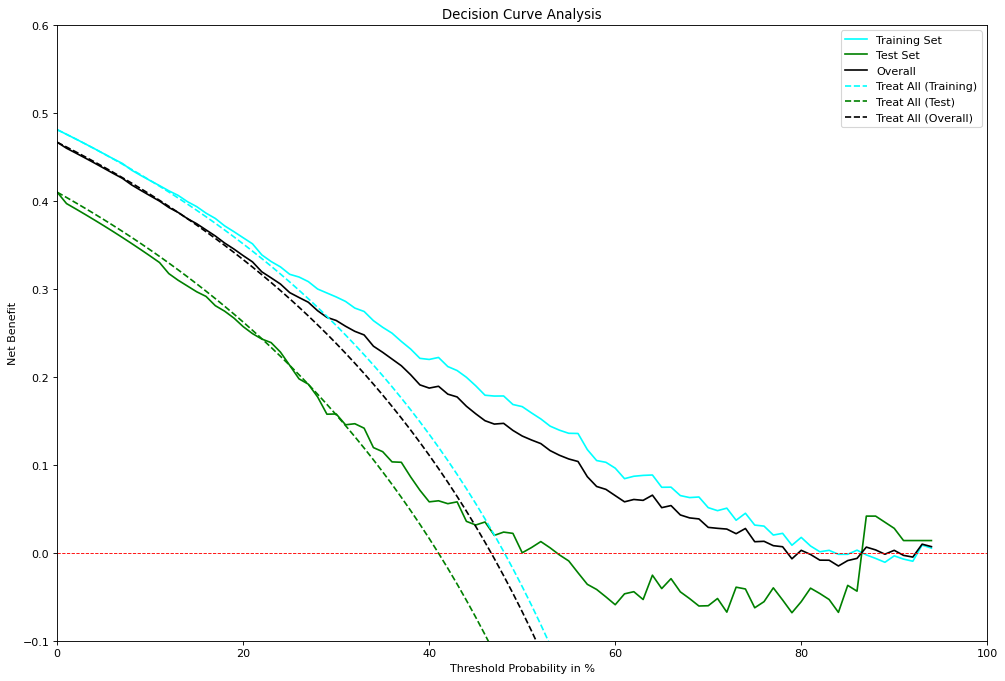

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 加载数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_selected_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx'

features_data = pd.read_excel(file_path_features)
selected_features_data = pd.read_excel(file_path_selected_features)

# 根据LASSO筛选的特征系数不为0的特征
non_zero_features = selected_features_data[selected_features_data['Coefficient'] != 0]['Feature'].values
X = features_data[non_zero_features].values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集（8:2比例）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用逻辑回归模型
logistic_regression = LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train, y_train)

# 计算预测概率
y_train_pred_proba = logistic_regression.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
y_pred_proba = logistic_regression.predict_proba(X_scaled)[:, 1]

# 决策曲线分析函数
def decision_curve_analysis(y_true, y_pred_proba, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    for p in np.arange(p_min, p_max, epsilon):
        y_pred = y_pred_proba > p
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n = tn + fp + fn + tp
        net_benefit = (tp / n) - (fp / n) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Net Benefit Prioritise All Referrals
def calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    total = tp_test + tn_test
    for p in np.arange(p_min, p_max, epsilon):
        net_benefit = (tp_test / total) - (tn_test / total) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Plotting the Decision Curves
def plot_decision_curves(clfs, labels, X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, name):
    tp_test = np.sum(y_test)
    tn_test = y_test.shape[0] - tp_test
    tp_train = np.sum(y_train)
    tn_train = y_train.shape[0] - tp_train
    tp_overall = np.sum(y)
    tn_overall = y.shape[0] - tp_overall

    plt.figure(figsize=(15, 10), dpi=80)

    # 计算训练集、测试集和总体的决策曲线
    p_train, net_benefit_train = decision_curve_analysis(y_train, clfs[0].predict_proba(X_train)[:, 1], p_min, p_max, epsilon)
    p_test, net_benefit_test = decision_curve_analysis(y_test, clfs[1].predict_proba(X_test)[:, 1], p_min, p_max, epsilon)
    p_overall, net_benefit_overall = decision_curve_analysis(y, clfs[2].predict_proba(X_scaled)[:, 1], p_min, p_max, epsilon)

    # 绘制决策曲线
    plt.plot(p_train, net_benefit_train, label='Training Set', color='cyan')
    plt.plot(p_test, net_benefit_test, label='Test Set', color='green')
    plt.plot(p_overall, net_benefit_overall, label='Overall', color='black')

    # 绘制“Treat All”参考线
    p_all_train, net_benefit_all_train = calculate_net_benefit_all(tp_train, tn_train, p_min, p_max, epsilon)
    p_all_test, net_benefit_all_test = calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon)
    p_all_overall, net_benefit_all_overall = calculate_net_benefit_all(tp_overall, tn_overall, p_min, p_max, epsilon)
    plt.plot(p_all_train, net_benefit_all_train, label='Treat All (Training)', linestyle='dashed', color='cyan')
    plt.plot(p_all_test, net_benefit_all_test, label='Treat All (Test)', linestyle='dashed', color='green')
    plt.plot(p_all_overall, net_benefit_all_overall, label='Treat All (Overall)', linestyle='dashed', color='black')

    # 添加 y=0 的红色虚线
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)

    plt.xlabel('Threshold Probability in %')
    plt.ylabel('Net Benefit')
    plt.title('Decision Curve Analysis')
    plt.ylim([-0.1, 0.60])  # 设置y轴的显示范围为-0.05到0.90
    plt.xlim([0, 100])  # 设置x轴的显示范围为0到100
    plt.legend()
    plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\DCA2_%s.tiff' % (name), dpi=300)
    plt.show()

# 设置参数
p_min = 0.00
p_max = 0.95
epsilon = 0.01

# 执行决策曲线分析
plot_decision_curves([logistic_regression, logistic_regression, logistic_regression], ['Training Set', 'Test Set', 'Overall'], X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, 'DCA_LogisticRegression')

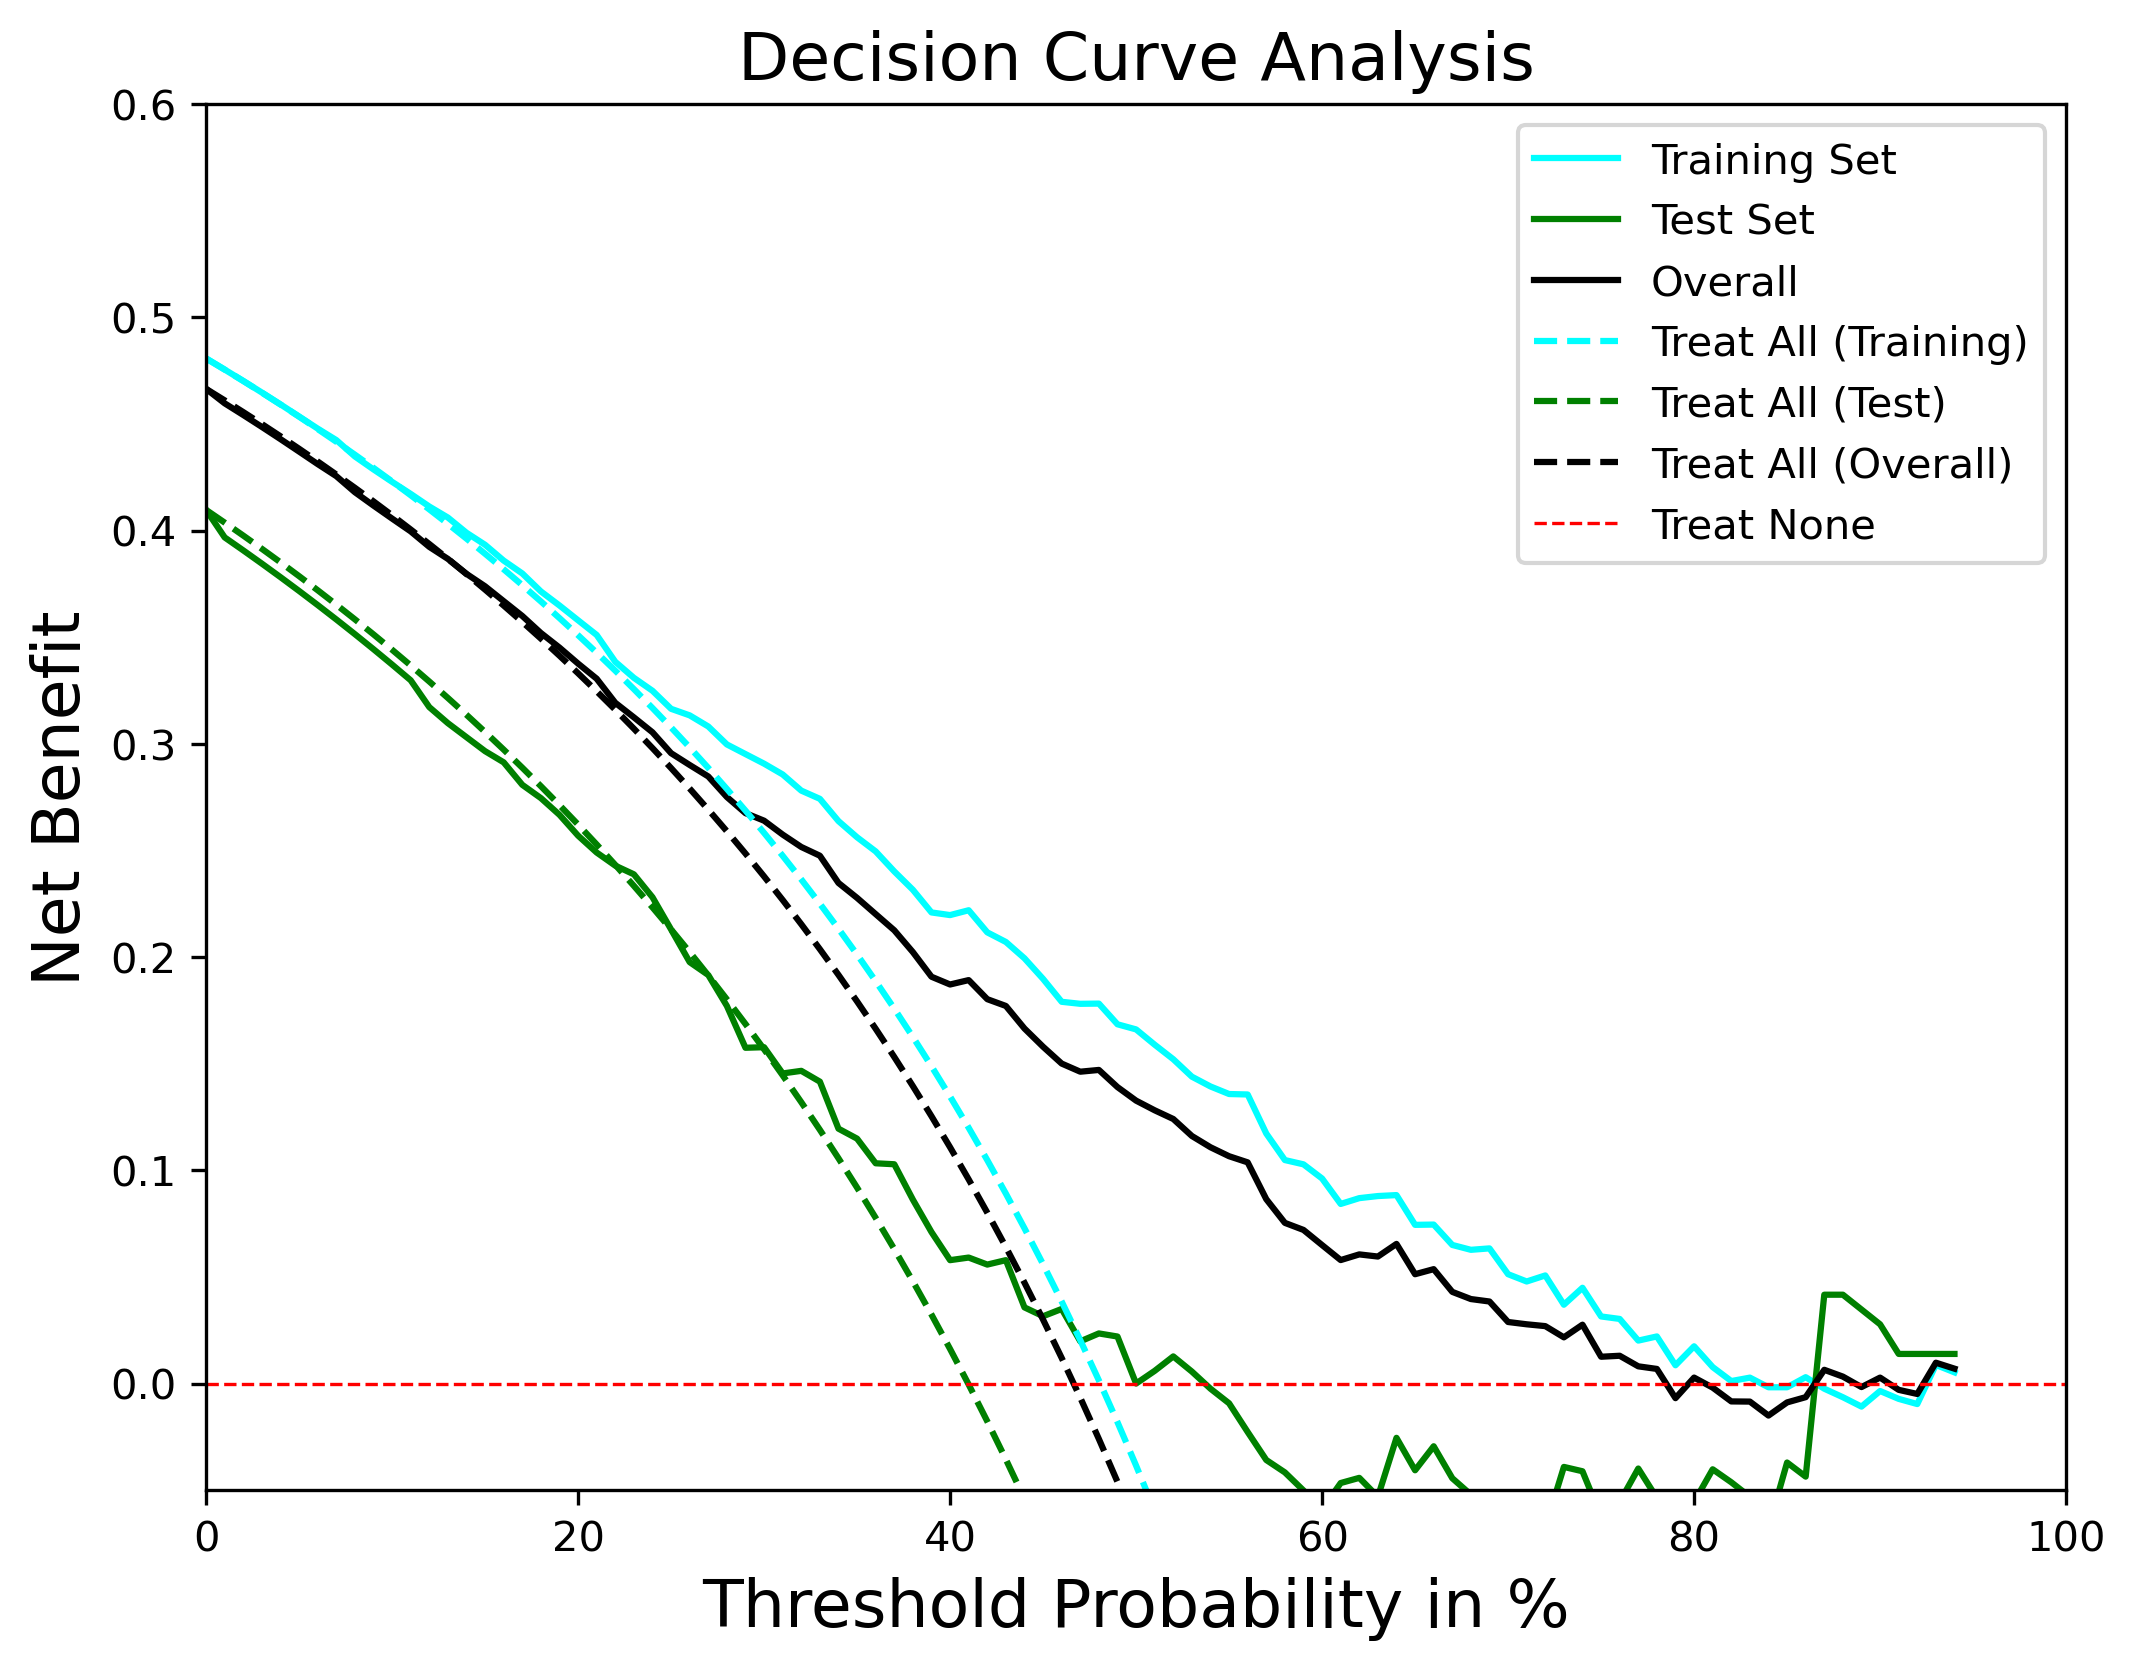

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 加载数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_selected_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx'

features_data = pd.read_excel(file_path_features)
selected_features_data = pd.read_excel(file_path_selected_features)

# 根据LASSO筛选的特征系数不为0的特征
non_zero_features = selected_features_data[selected_features_data['Coefficient'] != 0]['Feature'].values
X = features_data[non_zero_features].values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集（8:2比例）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用逻辑回归模型
logistic_regression = LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train, y_train)

# 计算预测概率
y_train_pred_proba = logistic_regression.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
y_pred_proba = logistic_regression.predict_proba(X_scaled)[:, 1]

# 决策曲线分析函数
def decision_curve_analysis(y_true, y_pred_proba, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    for p in np.arange(p_min, p_max, epsilon):
        y_pred = y_pred_proba > p
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n = tn + fp + fn + tp
        net_benefit = (tp / n) - (fp / n) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Net Benefit Prioritise All Referrals
def calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    total = tp_test + tn_test
    for p in np.arange(p_min, p_max, epsilon):
        net_benefit = (tp_test / total) - (tn_test / total) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Plotting the Decision Curves
def plot_decision_curves(clfs, labels, X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, name):
    tp_test = np.sum(y_test)
    tn_test = y_test.shape[0] - tp_test
    tp_train = np.sum(y_train)
    tn_train = y_train.shape[0] - tp_train
    tp_overall = np.sum(y)
    tn_overall = y.shape[0] - tp_overall

    plt.figure(figsize=(8, 6), dpi=300)

   # 计算训练集、测试集和总体的决策曲线
    p_train, net_benefit_train = decision_curve_analysis(y_train, clfs[0].predict_proba(X_train)[:, 1], p_min, p_max, epsilon)
    p_test, net_benefit_test = decision_curve_analysis(y_test, clfs[1].predict_proba(X_test)[:, 1], p_min, p_max, epsilon)
    p_overall, net_benefit_overall = decision_curve_analysis(y, clfs[2].predict_proba(X_scaled)[:, 1], p_min, p_max, epsilon)

    # 绘制决策曲线
    plt.plot(p_train, net_benefit_train, label='Training Set', color='cyan')
    plt.plot(p_test, net_benefit_test, label='Test Set', color='green')
    plt.plot(p_overall, net_benefit_overall, label='Overall', color='black')

    # 绘制“Treat All”参考线
    p_all_train, net_benefit_all_train = calculate_net_benefit_all(tp_train, tn_train, p_min, p_max, epsilon)
    p_all_test, net_benefit_all_test = calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon)
    p_all_overall, net_benefit_all_overall = calculate_net_benefit_all(tp_overall, tn_overall, p_min, p_max, epsilon)
    plt.plot(p_all_train, net_benefit_all_train, label='Treat All (Training)', linestyle='dashed', color='cyan')
    plt.plot(p_all_test, net_benefit_all_test, label='Treat All (Test)', linestyle='dashed', color='green')
    plt.plot(p_all_overall, net_benefit_all_overall, label='Treat All (Overall)', linestyle='dashed', color='black')

    # 添加 y=0 的红色虚线，并添加图注
    y_equals_zero_line = plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Treat None')
    

    plt.xlabel('Threshold Probability in %', fontsize=16)
    plt.ylabel('Net Benefit', fontsize=16)
    plt.title('Decision Curve Analysis', fontsize=16)
    plt.ylim([-0.05, 0.60])  # 设置y轴的显示范围为-0.05到0.90
    plt.xlim([0, 100])  # 设置x轴的显示范围为0到100
    plt.legend(loc='best')  # 将图例放置在最佳位置
    plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\DCA_%s.tiff' % (name), dpi=300)
    plt.show()

# 设置参数
p_min = 0.00
p_max = 0.95
epsilon = 0.01

# 执行决策曲线分析
plot_decision_curves([logistic_regression, logistic_regression, logistic_regression], ['Training Set', 'Test Set', 'Overall'], X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, 'DCA_LogisticRegression')

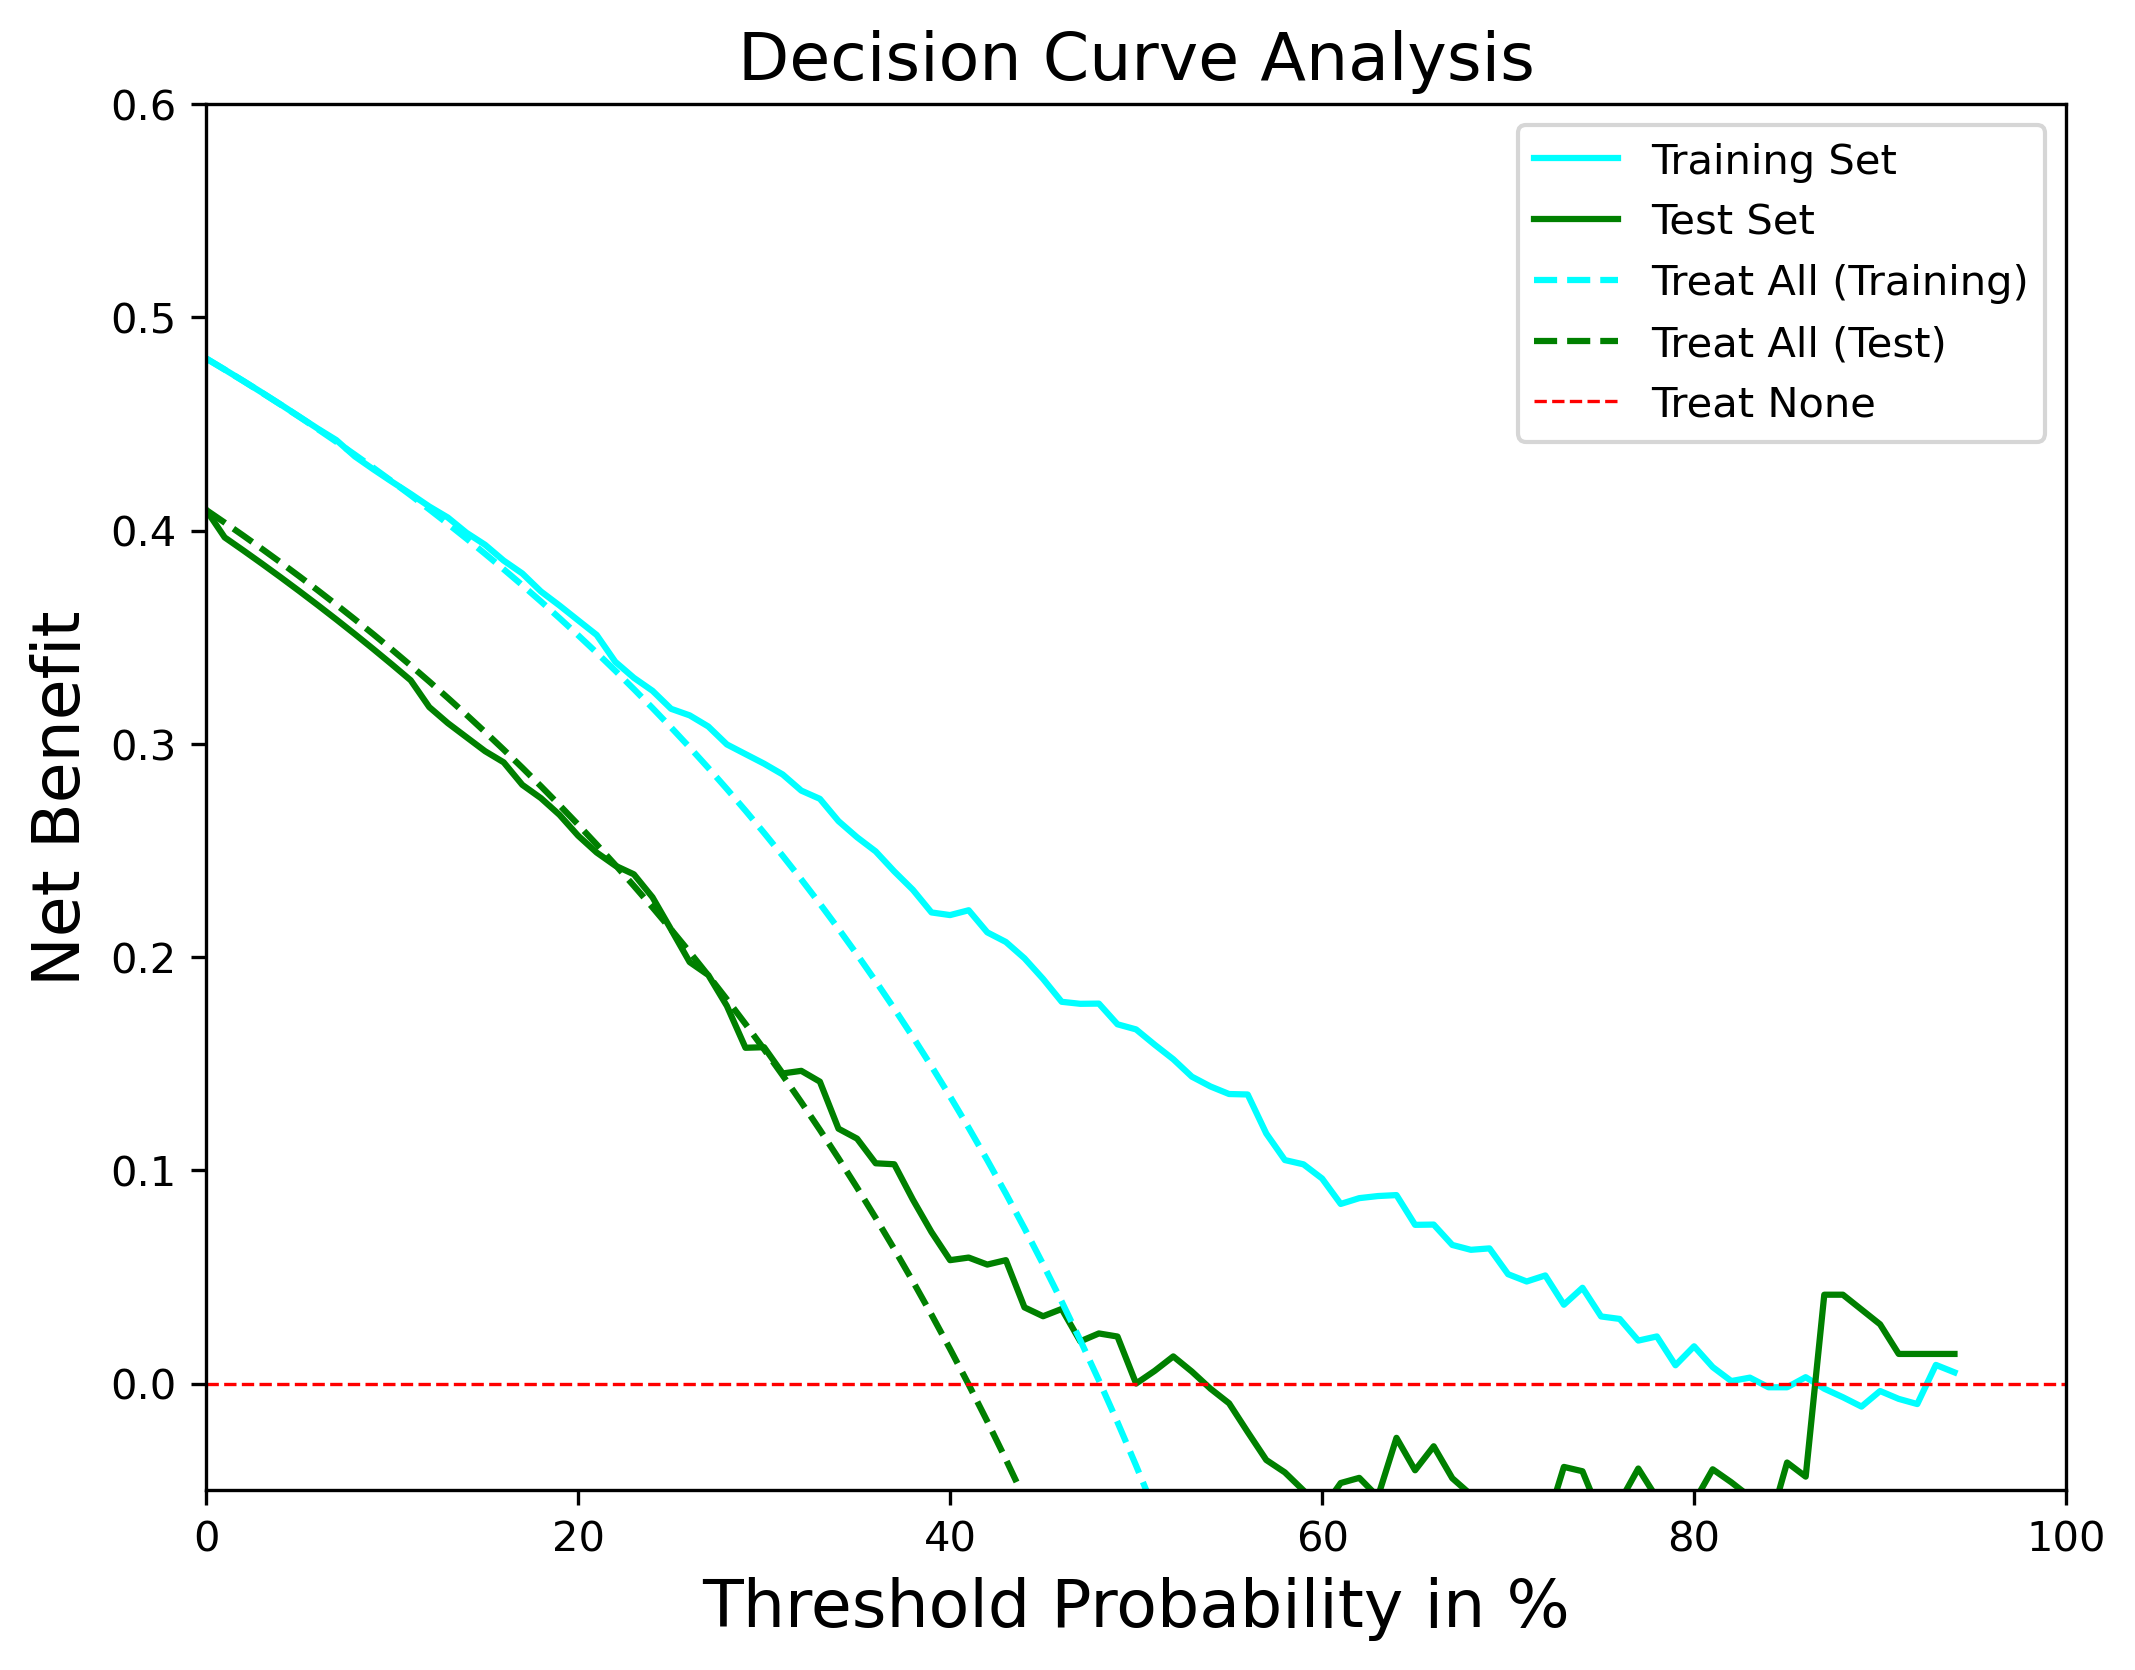

In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 加载数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_selected_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx'

features_data = pd.read_excel(file_path_features)
selected_features_data = pd.read_excel(file_path_selected_features)

# 根据LASSO筛选的特征系数不为0的特征
non_zero_features = selected_features_data[selected_features_data['Coefficient'] != 0]['Feature'].values
X = features_data[non_zero_features].values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集（8:2比例）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用逻辑回归模型
logistic_regression = LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train, y_train)

# 计算预测概率
y_train_pred_proba = logistic_regression.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
y_pred_proba = logistic_regression.predict_proba(X_scaled)[:, 1]

# 决策曲线分析函数
def decision_curve_analysis(y_true, y_pred_proba, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    for p in np.arange(p_min, p_max, epsilon):
        y_pred = y_pred_proba > p
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n = tn + fp + fn + tp
        net_benefit = (tp / n) - (fp / n) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Net Benefit Prioritise All Referrals
def calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    total = tp_test + tn_test
    for p in np.arange(p_min, p_max, epsilon):
        net_benefit = (tp_test / total) - (tn_test / total) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Plotting the Decision Curves
def plot_decision_curves(clfs, labels, X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, name):
    tp_test = np.sum(y_test)
    tn_test = y_test.shape[0] - tp_test
    tp_train = np.sum(y_train)
    tn_train = y_train.shape[0] - tp_train
    tp_overall = np.sum(y)
    tn_overall = y.shape[0] - tp_overall

    plt.figure(figsize=(8, 6), dpi=300)

   # 计算训练集、测试集和总体的决策曲线
    p_train, net_benefit_train = decision_curve_analysis(y_train, clfs[0].predict_proba(X_train)[:, 1], p_min, p_max, epsilon)
    p_test, net_benefit_test = decision_curve_analysis(y_test, clfs[1].predict_proba(X_test)[:, 1], p_min, p_max, epsilon)
 #   p_overall, net_benefit_overall = decision_curve_analysis(y, clfs[2].predict_proba(X_scaled)[:, 1], p_min, p_max, epsilon)

    # 绘制决策曲线
    plt.plot(p_train, net_benefit_train, label='Training Set', color='cyan')
    plt.plot(p_test, net_benefit_test, label='Test Set', color='green')
#    plt.plot(p_overall, net_benefit_overall, label='Overall', color='black')

    # 绘制“Treat All”参考线
    p_all_train, net_benefit_all_train = calculate_net_benefit_all(tp_train, tn_train, p_min, p_max, epsilon)
    p_all_test, net_benefit_all_test = calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon)
 #   p_all_overall, net_benefit_all_overall = calculate_net_benefit_all(tp_overall, tn_overall, p_min, p_max, epsilon)
    plt.plot(p_all_train, net_benefit_all_train, label='Treat All (Training)', linestyle='dashed', color='cyan')
    plt.plot(p_all_test, net_benefit_all_test, label='Treat All (Test)', linestyle='dashed', color='green')
#    plt.plot(p_all_overall, net_benefit_all_overall, label='Treat All (Overall)', linestyle='dashed', color='black')

    # 添加 y=0 的红色虚线，并添加图注
    y_equals_zero_line = plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Treat None')
    

    plt.xlabel('Threshold Probability in %', fontsize=16)
    plt.ylabel('Net Benefit', fontsize=16)
    plt.title('Decision Curve Analysis', fontsize=16)
    plt.ylim([-0.05, 0.60])  # 设置y轴的显示范围为-0.05到0.90
    plt.xlim([0, 100])  # 设置x轴的显示范围为0到100
    plt.legend(loc='best')  # 将图例放置在最佳位置
    plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\DCA_%s2.tiff' % (name), dpi=300)
    plt.show()

# 设置参数
p_min = 0.00
p_max = 0.95
epsilon = 0.01

# 执行决策曲线分析
plot_decision_curves([logistic_regression, logistic_regression, logistic_regression], ['Training Set', 'Test Set', 'Overall'], X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, 'DCA_LogisticRegression')

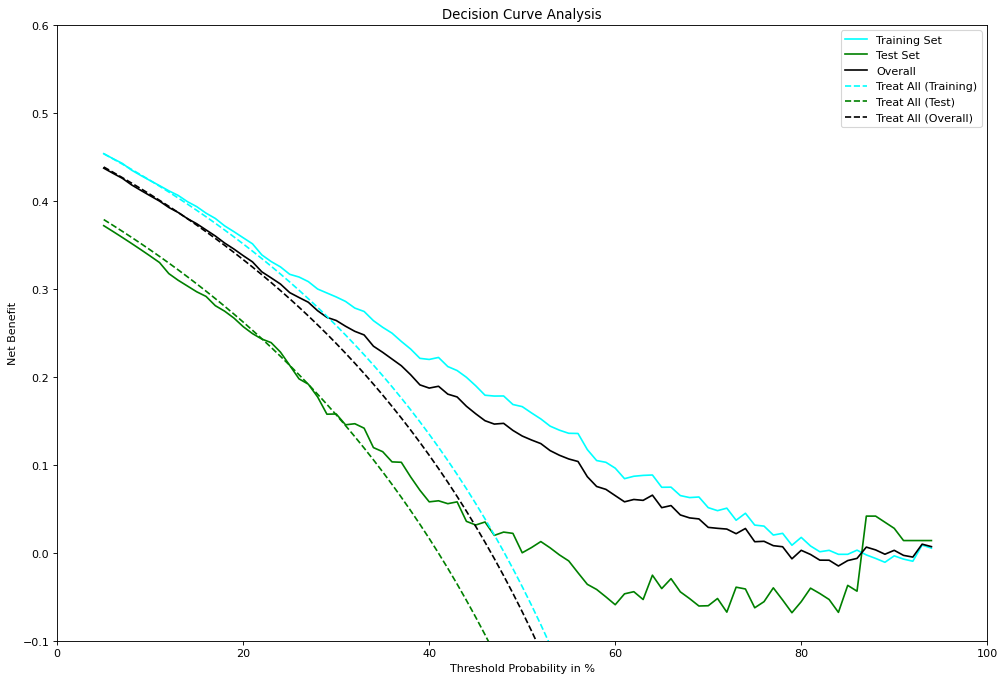

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 加载数据
file_path_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx'
file_path_selected_features = r'C:\Users\Admin\Desktop\数据分析\亚组分析\selected_features.xlsx'

features_data = pd.read_excel(file_path_features)
selected_features_data = pd.read_excel(file_path_selected_features)

# 根据LASSO筛选的特征系数不为0的特征
non_zero_features = selected_features_data[selected_features_data['Coefficient'] != 0]['Feature'].values
X = features_data[non_zero_features].values
y = features_data['Label'].values

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集（8:2比例）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用逻辑回归模型
logistic_regression = LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train, y_train)

# 计算预测概率
y_train_pred_proba = logistic_regression.predict_proba(X_train)[:, 1]
y_test_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
y_pred_proba = logistic_regression.predict_proba(X_scaled)[:, 1]

# 决策曲线分析函数
def decision_curve_analysis(y_true, y_pred_proba, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    for p in np.arange(p_min, p_max, epsilon):
        y_pred = y_pred_proba > p
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n = tn + fp + fn + tp
        net_benefit = (tp / n) - (fp / n) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Net Benefit Prioritise All Referrals
def calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon):
    p_serie = []
    net_benefit_serie = []
    total = tp_test + tn_test
    for p in np.arange(p_min, p_max, epsilon):
        net_benefit = (tp_test / total) - (tn_test / total) * (p / (1 - p))
        p_serie.append(p * 100)
        net_benefit_serie.append(net_benefit)
    return p_serie, net_benefit_serie

# Plotting the Decision Curves
def plot_decision_curves(clfs, labels, X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, name):
    tp_test = np.sum(y_test)
    tn_test = y_test.shape[0] - tp_test
    tp_train = np.sum(y_train)
    tn_train = y_train.shape[0] - tp_train
    tp_overall = np.sum(y)
    tn_overall = y.shape[0] - tp_overall

    plt.figure(figsize=(15, 10), dpi=80)

    # 计算训练集、测试集和总体的决策曲线
    p_train, net_benefit_train = decision_curve_analysis(y_train, clfs[0].predict_proba(X_train)[:, 1], p_min, p_max, epsilon)
    p_test, net_benefit_test = decision_curve_analysis(y_test, clfs[1].predict_proba(X_test)[:, 1], p_min, p_max, epsilon)
    p_overall, net_benefit_overall = decision_curve_analysis(y, clfs[2].predict_proba(X_scaled)[:, 1], p_min, p_max, epsilon)

    # 绘制决策曲线
    plt.plot(p_train, net_benefit_train, label='Training Set', color='cyan')
    plt.plot(p_test, net_benefit_test, label='Test Set', color='green')
    plt.plot(p_overall, net_benefit_overall, label='Overall', color='black')

    # 绘制“Treat All”参考线
    p_all_train, net_benefit_all_train = calculate_net_benefit_all(tp_train, tn_train, p_min, p_max, epsilon)
    p_all_test, net_benefit_all_test = calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon)
    p_all_overall, net_benefit_all_overall = calculate_net_benefit_all(tp_overall, tn_overall, p_min, p_max, epsilon)
    plt.plot(p_all_train, net_benefit_all_train, label='Treat All (Training)', linestyle='dashed', color='cyan')
    plt.plot(p_all_test, net_benefit_all_test, label='Treat All (Test)', linestyle='dashed', color='green')
    plt.plot(p_all_overall, net_benefit_all_overall, label='Treat All (Overall)', linestyle='dashed', color='black')

    plt.xlabel('Threshold Probability in %')
    plt.ylabel('Net Benefit')
    plt.title('Decision Curve Analysis')
    plt.ylim([-0.10, 0.60])  # 设置y轴的显示范围为-0.05到0.90
    plt.xlim([0, 100])  # 设置x轴的显示范围为0到100
    plt.legend()
    plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\DCA_%s.tiff' % (name), dpi=300)
    plt.show()

# 设置参数
p_min = 0.05
p_max = 0.95
epsilon = 0.01

# 执行决策曲线分析
plot_decision_curves([logistic_regression, logistic_regression, logistic_regression], ['Training Set', 'Test Set', 'Overall'], X_train, X_test, y_train, y_test, y, p_min, p_max, epsilon, 'DCA_LogisticRegression')

In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 加载数据
feature_file = pd.read_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\feature_file_all_new2.xlsx')
t_test_file = pd.read_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\t检验筛选出的指标.xlsx')

# 筛选t检验的特征
selected_features = t_test_file['Feature'].tolist()
X = feature_file[selected_features]
y = feature_file['Label']

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用逻辑回归模型
logistic = LogisticRegression(solver='liblinear', max_iter=1000)
logistic.fit(X_scaled, y)

# 计算每个患者的影像组学分数
radiomics_scores = logistic.decision_function(X_scaled)

# 创建一个DataFrame来保存影像组学分数和真实标签
scores_df = pd.DataFrame({
    'Patient ID': np.arange(1, len(radiomics_scores) + 1),  # 患者ID
    'Radiomics Score': radiomics_scores,  # 影像组学分数
    'True Label': y  # 真实标签
})

# 根据影像组学分数由小到大排列
scores_df_sorted = scores_df.sort_values(by='Radiomics Score', ascending=True)

# 保存到Excel文件
scores_df_sorted.to_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Radiomics_Scores.xlsx', index=False)

# 打印输出以确认
print(scores_df_sorted.head())  # 打印前几行以确认

     Patient ID  Radiomics Score  True Label
342         343        -4.321005           0
514         515        -3.096807           1
202         203        -2.640231           0
11           12        -2.614357           0
572         573        -2.542771           1


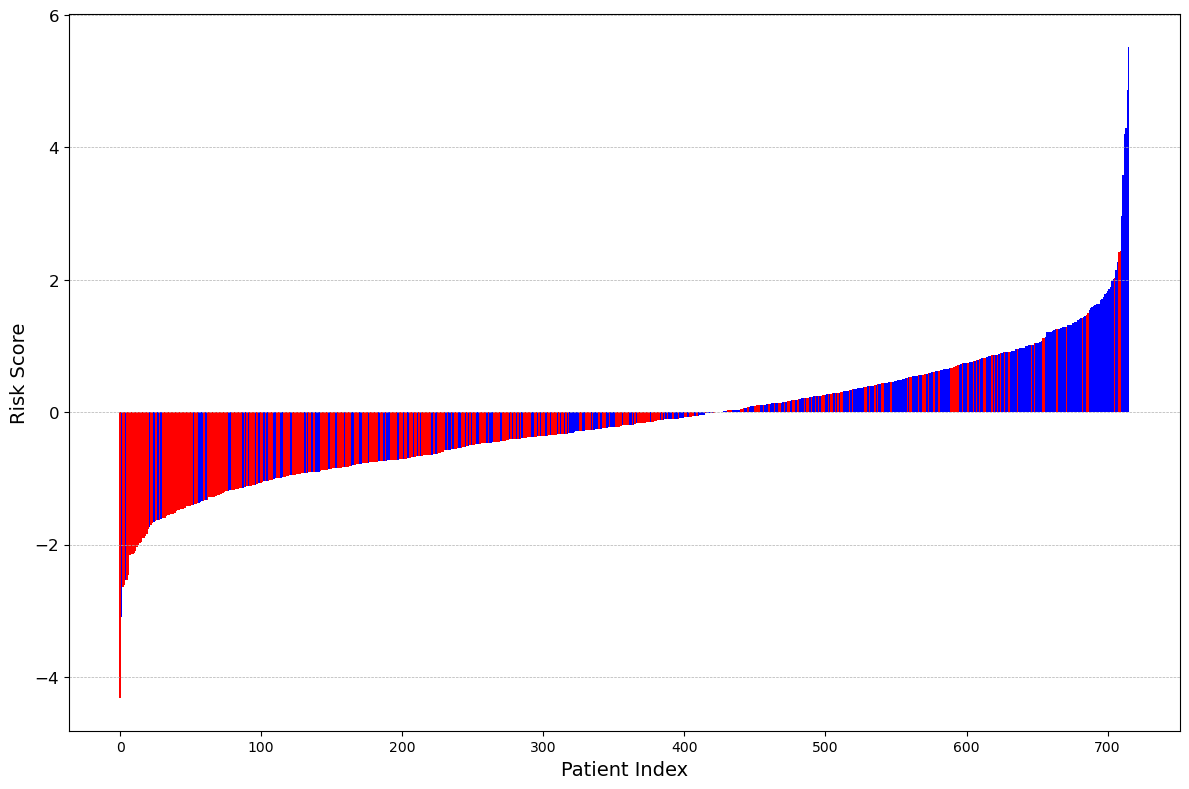

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 从Excel文件中加载数据
scores_df = pd.read_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Radiomics_Scores.xlsx')

# 分离患者序号、Radiomics Score和真实标签
patient_ids = scores_df['Patient ID']
radiomics_scores = scores_df['Radiomics Score']
true_labels = scores_df['True Label']

# 绘制柱状图，使用不同颜色表示患者的真实标签值
plt.figure(figsize=(12, 8))
colors = ['red' if label == 0 else 'blue' for label in true_labels]

# 绘制柱状图，移除边框，设置柱子宽度为1以消除间隙
bar_plot = plt.bar(range(len(patient_ids)), radiomics_scores, color=colors, edgecolor='none', width=1)

# 添加数字标记
ticks = np.arange(0, len(patient_ids), 100)
plt.xticks(ticks, ticks , rotation=0)

plt.xlabel('Patient Index', fontsize=14)
plt.ylabel('Risk Score', fontsize=14)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')


plt.tight_layout()  # 调整布局以防止标签被截断
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\Radiomics_Scores_Plot2.tiff', dpi=300, bbox_inches='tight')
plt.show()

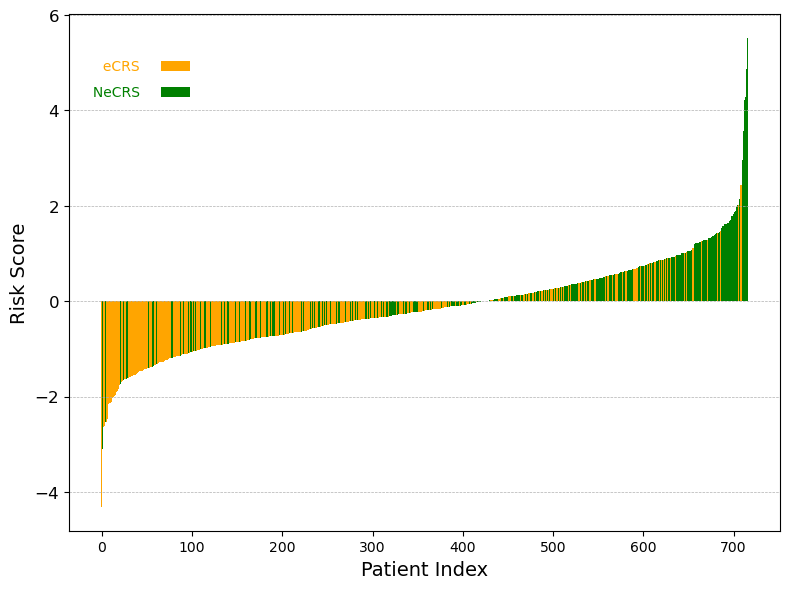

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 从Excel文件中加载数据
scores_df = pd.read_excel(r'C:\Users\Admin\Desktop\数据分析\亚组分析\Radiomics_Scores.xlsx')

# 分离患者序号、Radiomics Score和真实标签
patient_ids = scores_df['Patient ID']
radiomics_scores = scores_df['Radiomics Score']
true_labels = scores_df['True Label']

# 绘制柱状图，使用不同颜色表示患者的真实标签值
plt.figure(figsize=(8, 6))
colors = ['orange' if label == 0 else 'green' for label in true_labels]

# 绘制柱状图，移除边框，设置柱子宽度为1以消除间隙
bar_plot = plt.bar(range(len(patient_ids)), radiomics_scores, color=colors, edgecolor='none', width=1)

# 添加数字标记
ticks = np.arange(0, len(patient_ids), 100)
plt.xticks(ticks, ticks, rotation=0)

plt.xlabel('Patient Index', fontsize=14)
plt.ylabel('Risk Score', fontsize=14)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# 添加带有红色矩形的标签"eCRS"
plt.text(0.1, 0.90, '     eCRS', transform=plt.gca().transAxes, fontsize=10, weight='light', color='orange', va='center', ha='right')
plt.gca().add_patch(plt.Rectangle((0.13, 0.89), 0.04, 0.02, facecolor='orange', edgecolor='none', transform=plt.gca().transAxes))

# 添加带有蓝色矩形的标签"NeCRS"
plt.text(0.1, 0.85, '     NeCRS', transform=plt.gca().transAxes, fontsize=10, weight='light', color='green', va='center', ha='right')
plt.gca().add_patch(plt.Rectangle((0.13, 0.84), 0.04, 0.02, facecolor='green', edgecolor='none', transform=plt.gca().transAxes))

plt.tight_layout()  # 调整布局以防止标签被截断
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\Radiomics_Scores_Plot2.tiff', dpi=300, bbox_inches='tight')
plt.show()

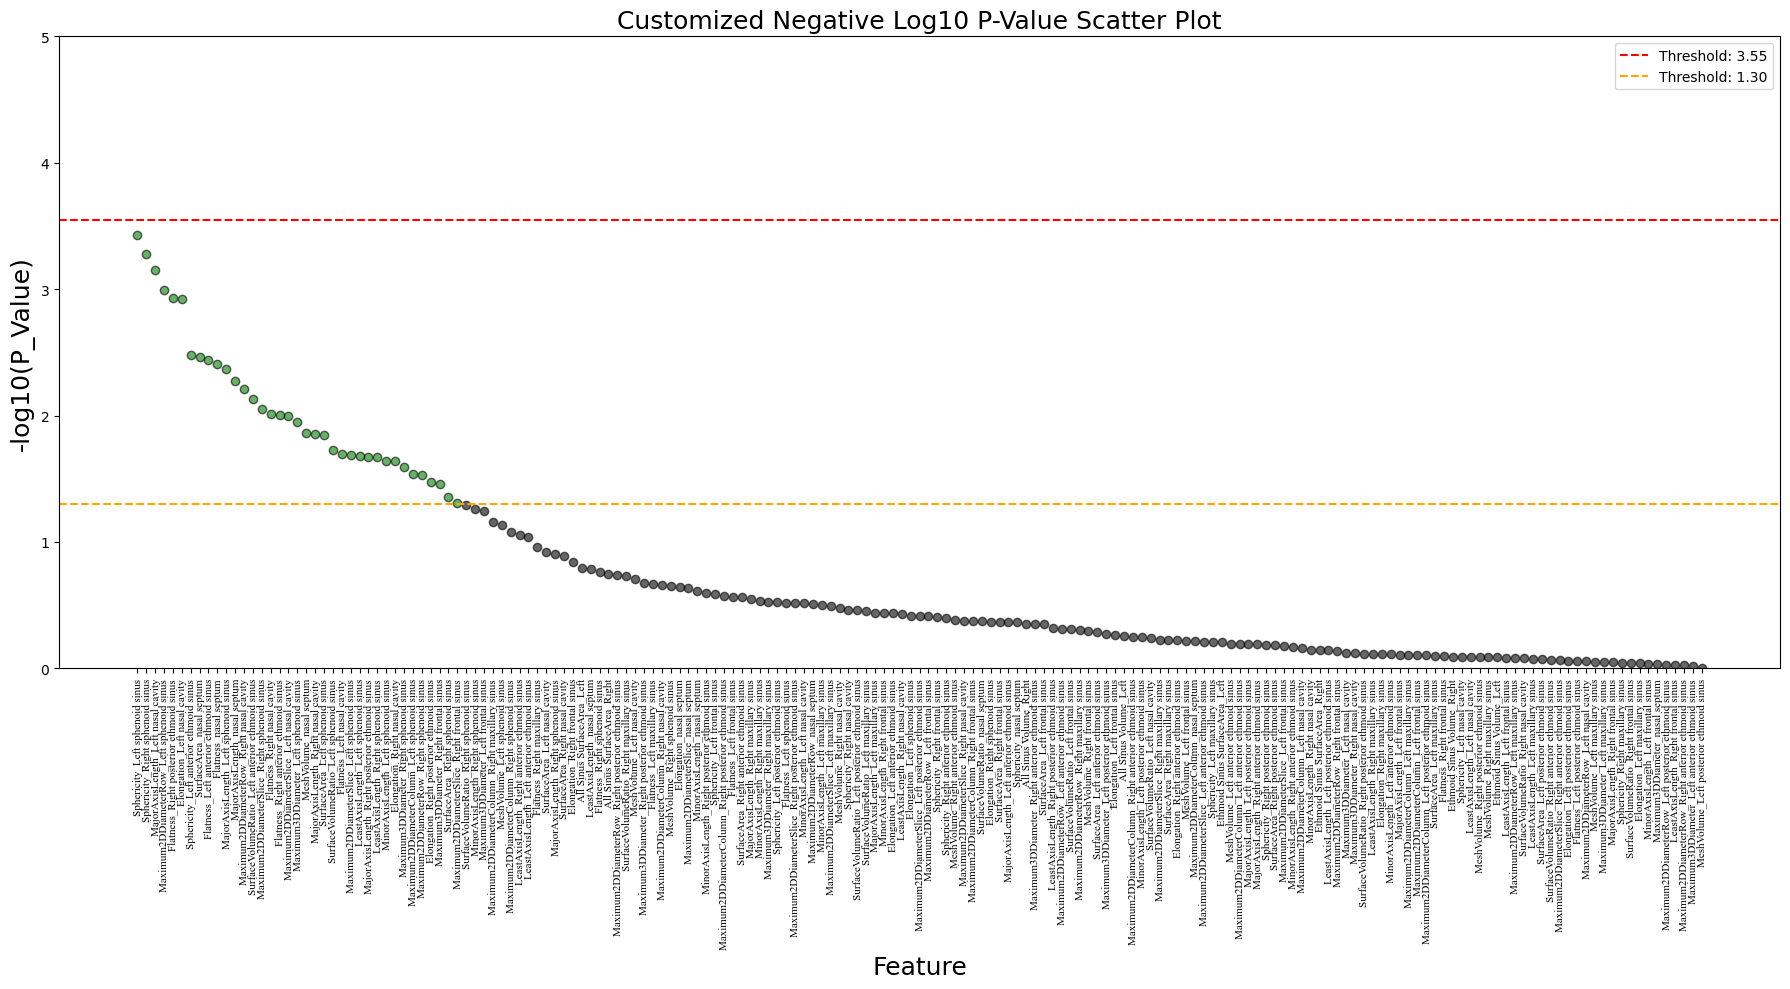

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.font_manager import FontProperties
import os

# 读取数据
file_path = r'C:\Users\Admin\Desktop\数据分析\亚组分析\p值5.xlsx'
data = pd.read_excel(file_path)

# 将p值转换为负对数值
data['Negative_Log_P_Value'] = -np.log10(data['P_Value'])


# 定义颜色映射
norm = Normalize(vmin=-np.log10(1), vmax=-np.log10(data['P_Value'].min()))
cmap = plt.get_cmap('viridis')

# 绘制点状图
plt.figure(figsize=(18, 10))
for i, row in data.iterrows():
    color = cmap(norm(-row['Negative_Log_P_Value']))
    if row['Negative_Log_P_Value'] > 3.55:
        plt.scatter(row['Feature'], row['Negative_Log_P_Value'], color='yellow', alpha=0.6, edgecolor='black')
    if 3.55 > row['Negative_Log_P_Value'] > 1.30:
        plt.scatter(row['Feature'], row['Negative_Log_P_Value'], color='green', alpha=0.6, edgecolor='black')
    if row['Negative_Log_P_Value'] <1.30:
        plt.scatter(row['Feature'], row['Negative_Log_P_Value'], color='black', alpha=0.6, edgecolor='black')

# 绘制红线
plt.axhline(3.55, color='red', linestyle='--', label='Threshold: 3.55')
plt.axhline(1.30, color='orange', linestyle='--', label='Threshold: 1.30')

font_x = FontProperties(family='Times New Roman', size=8, weight='light')
plt.xticks(fontproperties=font_x)
plt.xlabel('Feature',fontsize=18)
plt.ylabel('-log10(P_Value)',fontsize=18)
plt.ylim(0, 5)
plt.title('Customized Negative Log10 P-Value Scatter Plot',fontsize=18)
plt.legend()
plt.xticks(rotation=90)  # 旋转x轴标签，以便更好地显示
plt.tight_layout()  # 自动调整子图参数，以便填充整个图像区域
plt.savefig(r'C:\Users\Admin\Desktop\数据分析\亚组分析\结果图\customized_negative_log_p_value_1 VS 2.tiff', dpi=300, bbox_inches='tight')
plt.show()
